In [13]:
import optuna
from optuna.samplers import TPESampler
from sklearn.model_selection import KFold, cross_val_predict, GridSearchCV, cross_validate,cross_val_score
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import joblib

In [ ]:
import os
os.chdir(r'C:\Users\ADMIN\Desktop\EMLforSAI')  #Replace with the file path of EMLforSAI in your system.

In [ ]:
# 1. 读取数据
df=pd.read_csv(r'./Dataset/ML_data.csv')

In [ ]:
# 2. 数据预处理
df = df.dropna(subset=['y'])
feature_columns = ['A1', 'A2', 'A3', 'A4', 'B1', 'B2', 'B3', 'B4', 'B5', 
                   'C1', 'C2', 'C3', 'C4']

def categorize_y(value):
    if pd.isna(value):
        return np.nan
    elif value <= 3:
        return 2
    elif value == 4:
        return 1
    elif value == 5:
        return 0
    else:
        return np.nan

df['y_category'] = df['y'].apply(categorize_y)
df = df.dropna(subset=['y_category'])

X = df[feature_columns]
y = df['y_category']

In [4]:
# 3. 设置五折交叉验证
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

print("=== Optuna贝叶斯优化调参 (MLP分类) ===")
print(f"样本数: {len(X)}, 特征数: {len(feature_columns)}")
print(f"类别分布: {dict(y.value_counts().sort_index())}")
print(f"类别比例: {y.value_counts(normalize=True).sort_index().values}")

# 4. 定义Optuna目标函数 (针对MLP分类)
def objective(trial):
    """
    Optuna目标函数，返回交叉验证的准确率
    """
    # 定义MLP参数搜索空间
    
    # 首先选择隐藏层层数 (1-4层)
    n_layers = trial.suggest_int('n_layers', 1, 4)
    
    # 根据层数创建隐藏层结构
    hidden_layer_sizes = []
    for i in range(n_layers):
        # 每层的神经元数量，可以有不同的搜索范围
        if i == 0:  # 第一层
            n_neurons = trial.suggest_int(f'layer_{i}_neurons', 32, 512)
        elif i == n_layers - 1:  # 最后一层
            n_neurons = trial.suggest_int(f'layer_{i}_neurons', 16, 256)
        else:  # 中间层
            n_neurons = trial.suggest_int(f'layer_{i}_neurons', 16, 256)
        hidden_layer_sizes.append(n_neurons)
    
    params = {
        # 网络结构参数
        'hidden_layer_sizes': tuple(hidden_layer_sizes),
        
        # 激活函数
        'activation': trial.suggest_categorical('activation', ['relu', 'tanh', 'logistic']),
        
        # 优化器
        'solver': trial.suggest_categorical('solver', ['adam', 'sgd', 'lbfgs']),
        
        # 学习率参数（仅对adam和sgd有效）
        'learning_rate': trial.suggest_categorical('learning_rate', ['constant', 'invscaling', 'adaptive']),
        
        # 学习率初始值
        'learning_rate_init': trial.suggest_float('learning_rate_init', 1e-4, 1e-1, log=True),
        
        # 动量（仅对sgd有效）
        'momentum': trial.suggest_float('momentum', 0.5, 0.99),
        
        # 正则化参数
        'alpha': trial.suggest_float('alpha', 1e-6, 1e-1, log=True),
        
        # 批次大小
        'batch_size': trial.suggest_categorical('batch_size', ['auto', 16, 32, 64, 128, 256]),
        
        # 最大迭代次数
        'max_iter': trial.suggest_int('max_iter', 200, 2000),
        
        # 是否使用早停
        'early_stopping': trial.suggest_categorical('early_stopping', [True, False]),
        
        # 验证集比例
        'validation_fraction': trial.suggest_float('validation_fraction', 0.05, 0.3),
        
        # 随机种子
        'random_state': 42,
        
        # 容差
        'tol': trial.suggest_float('tol', 1e-5, 1e-3, log=True),
        
        # 是否使用nesterov动量
        'nesterovs_momentum': trial.suggest_categorical('nesterovs_momentum', [True, False]),
        
        # beta参数（adam优化器）
        'beta_1': trial.suggest_float('beta_1', 0.8, 0.999),
        'beta_2': trial.suggest_float('beta_2', 0.9, 0.9999),
        
        # 是否打乱数据
        'shuffle': trial.suggest_categorical('shuffle', [True, False]),
        
        # 是否启用warm_start
        'warm_start': trial.suggest_categorical('warm_start', [False]),  # 通常关闭以减少内存使用
    }
    
    # 根据优化器调整参数
    if params['solver'] == 'lbfgs':
        # lbfgs不支持momentum和nesterovs_momentum
        params['momentum'] = 0.9  # 默认值
        params['nesterovs_momentum'] = False
        # lbfgs通常使用较小的batch_size
        if params['batch_size'] != 'auto':
            params['batch_size'] = min(params['batch_size'], 128)
    
    # 如果早停关闭，验证集比例设为0.1（默认值）
    if not params['early_stopping']:
        params['validation_fraction'] = 0.1
    
    # 创建包含标准化和MLP的Pipeline
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('mlp', MLPClassifier(**params))
    ])
    
    try:
        # 使用交叉验证计算分数
        scores = cross_val_score(pipeline, X, y, cv=kfold, scoring='accuracy', n_jobs=1)
        
        # 返回平均准确率
        return np.mean(scores)
    except Exception as e:
        # 如果训练失败，返回一个很低的分数
        print(f"训练失败: {e}, 参数: {params['hidden_layer_sizes']}")
        return 0.0

# 5. 创建Optuna研究并运行优化
print("\n开始Optuna贝叶斯优化...")
study = optuna.create_study(
    direction='maximize',  # 最大化准确率
    sampler=TPESampler(seed=42),  # 使用TPE采样器
    pruner=optuna.pruners.MedianPruner(n_startup_trials=10, n_warmup_steps=5, interval_steps=1)
)

# 运行优化
n_trials = 100  # 增加试验次数以探索更大的参数空间
study.optimize(objective, n_trials=n_trials, show_progress_bar=True)

[I 2025-12-20 13:43:47,328] A new study created in memory with name: no-name-2b964eb4-d7a1-4780-871d-c7907c14e9ff


=== Optuna贝叶斯优化调参 (MLP分类) ===
样本数: 687, 特征数: 13
类别分布: {0: 148, 1: 289, 2: 250}
类别比例: [0.2154294  0.42066958 0.36390102]

开始Optuna贝叶斯优化...


Best trial: 0. Best value: 0.780218:   1%|          | 1/100 [00:14<23:31, 14.25s/it]

[I 2025-12-20 13:44:01,581] Trial 0 finished with value: 0.7802179202369618 and parameters: {'n_layers': 2, 'layer_0_neurons': 489, 'layer_1_neurons': 192, 'activation': 'relu', 'solver': 'sgd', 'learning_rate': 'adaptive', 'learning_rate_init': 0.03142880890840111, 'momentum': 0.6040461642323554, 'alpha': 8.111941985431925e-06, 'batch_size': 256, 'max_iter': 451, 'early_stopping': False, 'validation_fraction': 0.16401749605425897, 'tol': 0.00037183641805732076, 'nesterovs_momentum': False, 'beta_1': 0.9178904992035465, 'beta_2': 0.9046403962307278, 'shuffle': True, 'warm_start': False}. Best is trial 0 with value: 0.7802179202369618.


Best trial: 0. Best value: 0.780218:   2%|▏         | 2/100 [00:14<10:04,  6.17s/it]

[I 2025-12-20 13:44:02,091] Trial 1 finished with value: 0.7030783878133925 and parameters: {'n_layers': 1, 'layer_0_neurons': 488, 'activation': 'relu', 'solver': 'sgd', 'learning_rate': 'invscaling', 'learning_rate_init': 0.053451661106468214, 'momentum': 0.6268021909840082, 'alpha': 0.002054051942538846, 'batch_size': 128, 'max_iter': 1892, 'early_stopping': True, 'validation_fraction': 0.2804685587557792, 'tol': 1.5030900645056805e-05, 'nesterovs_momentum': True, 'beta_1': 0.8647407358218896, 'beta_2': 0.9388288612399793, 'shuffle': False, 'warm_start': False}. Best is trial 0 with value: 0.7802179202369618.


Best trial: 0. Best value: 0.780218:   3%|▎         | 3/100 [00:17<07:21,  4.55s/it]

[I 2025-12-20 13:44:04,720] Trial 2 finished with value: 0.7714693748016502 and parameters: {'n_layers': 2, 'layer_0_neurons': 167, 'layer_1_neurons': 146, 'activation': 'tanh', 'solver': 'adam', 'learning_rate': 'invscaling', 'learning_rate_init': 0.015382308040279003, 'momentum': 0.8779224698761134, 'alpha': 2.3454342277260527e-06, 'batch_size': 32, 'max_iter': 760, 'early_stopping': False, 'validation_fraction': 0.2093893678388033, 'tol': 0.000594874681321977, 'nesterovs_momentum': True, 'beta_1': 0.941935712657376, 'beta_2': 0.9760024263568281, 'shuffle': False, 'warm_start': False}. Best is trial 0 with value: 0.7802179202369618.


Best trial: 0. Best value: 0.780218:   4%|▍         | 4/100 [00:21<06:52,  4.30s/it]

[I 2025-12-20 13:44:08,623] Trial 3 finished with value: 0.7409076483655982 and parameters: {'n_layers': 2, 'layer_0_neurons': 283, 'layer_1_neurons': 119, 'activation': 'tanh', 'solver': 'adam', 'learning_rate': 'constant', 'learning_rate_init': 0.01847793417351926, 'momentum': 0.6121111010908951, 'alpha': 2.4260488932164474e-06, 'batch_size': 32, 'max_iter': 1647, 'early_stopping': False, 'validation_fraction': 0.1848355604789127, 'tol': 0.00041198396246051877, 'nesterovs_momentum': True, 'beta_1': 0.8219003329810077, 'beta_2': 0.92277072273794, 'shuffle': False, 'warm_start': False}. Best is trial 0 with value: 0.7802179202369618.


Best trial: 0. Best value: 0.780218:   5%|▌         | 5/100 [00:21<04:27,  2.82s/it]

[I 2025-12-20 13:44:08,818] Trial 4 finished with value: 0.42064952924997356 and parameters: {'n_layers': 4, 'layer_0_neurons': 35, 'layer_1_neurons': 139, 'layer_2_neurons': 116, 'layer_3_neurons': 69, 'activation': 'logistic', 'solver': 'lbfgs', 'learning_rate': 'invscaling', 'learning_rate_init': 0.0005693074767644616, 'momentum': 0.7436517678872688, 'alpha': 3.194416563600365e-05, 'batch_size': 32, 'max_iter': 1835, 'early_stopping': True, 'validation_fraction': 0.17236319006939077, 'tol': 0.0009360540102485373, 'nesterovs_momentum': False, 'beta_1': 0.9515623034504148, 'beta_2': 0.9237399906448407, 'shuffle': True, 'warm_start': False}. Best is trial 0 with value: 0.7802179202369618.


Best trial: 0. Best value: 0.780218:   6%|▌         | 6/100 [00:32<08:35,  5.48s/it]

[I 2025-12-20 13:44:19,479] Trial 5 finished with value: 0.7728657569025705 and parameters: {'n_layers': 3, 'layer_0_neurons': 336, 'layer_1_neurons': 145, 'layer_2_neurons': 37, 'activation': 'relu', 'solver': 'lbfgs', 'learning_rate': 'invscaling', 'learning_rate_init': 0.008620220426018047, 'momentum': 0.5854395502124458, 'alpha': 0.0028489753426125656, 'batch_size': 16, 'max_iter': 1780, 'early_stopping': False, 'validation_fraction': 0.254305550050304, 'tol': 0.00012894414393074176, 'nesterovs_momentum': True, 'beta_1': 0.818527450793374, 'beta_2': 0.9896318542195374, 'shuffle': True, 'warm_start': False}. Best is trial 0 with value: 0.7802179202369618.


Best trial: 6. Best value: 0.794795:   7%|▋         | 7/100 [00:43<11:14,  7.25s/it]

[I 2025-12-20 13:44:30,362] Trial 6 finished with value: 0.7947953030783877 and parameters: {'n_layers': 2, 'layer_0_neurons': 199, 'layer_1_neurons': 190, 'activation': 'relu', 'solver': 'adam', 'learning_rate': 'constant', 'learning_rate_init': 0.00020156477059365003, 'momentum': 0.8251158668629474, 'alpha': 1.0600050132100276e-06, 'batch_size': 256, 'max_iter': 627, 'early_stopping': False, 'validation_fraction': 0.21240822476180365, 'tol': 0.0004993980255757075, 'nesterovs_momentum': True, 'beta_1': 0.8186412787977905, 'beta_2': 0.9367348087256374, 'shuffle': True, 'warm_start': False}. Best is trial 6 with value: 0.7947953030783877.


Best trial: 6. Best value: 0.794795:   8%|▊         | 8/100 [02:07<48:41, 31.76s/it]

[I 2025-12-20 13:45:54,600] Trial 7 finished with value: 0.7904157410345922 and parameters: {'n_layers': 4, 'layer_0_neurons': 221, 'layer_1_neurons': 230, 'layer_2_neurons': 168, 'layer_3_neurons': 207, 'activation': 'tanh', 'solver': 'sgd', 'learning_rate': 'invscaling', 'learning_rate_init': 0.06627897035983009, 'momentum': 0.9674250027312679, 'alpha': 0.03752510802193949, 'batch_size': 128, 'max_iter': 1736, 'early_stopping': False, 'validation_fraction': 0.2627841678792142, 'tol': 4.303720019143251e-05, 'nesterovs_momentum': False, 'beta_1': 0.9862948000579954, 'beta_2': 0.9695333766878298, 'shuffle': True, 'warm_start': False}. Best is trial 6 with value: 0.7947953030783877.


Best trial: 6. Best value: 0.794795:   9%|▉         | 9/100 [02:08<33:41, 22.22s/it]

[I 2025-12-20 13:45:55,830] Trial 8 finished with value: 0.7714482174970909 and parameters: {'n_layers': 3, 'layer_0_neurons': 508, 'layer_1_neurons': 49, 'layer_2_neurons': 140, 'activation': 'relu', 'solver': 'adam', 'learning_rate': 'adaptive', 'learning_rate_init': 0.054918878216015335, 'momentum': 0.7505577754418595, 'alpha': 0.0003217966164978636, 'batch_size': 128, 'max_iter': 876, 'early_stopping': False, 'validation_fraction': 0.058985568449185524, 'tol': 8.534852819566892e-05, 'nesterovs_momentum': True, 'beta_1': 0.9175758188532331, 'beta_2': 0.9030469749689111, 'shuffle': False, 'warm_start': False}. Best is trial 6 with value: 0.7947953030783877.


Best trial: 6. Best value: 0.794795:  10%|█         | 10/100 [02:12<24:45, 16.50s/it]

[I 2025-12-20 13:45:59,545] Trial 9 finished with value: 0.7714587961493705 and parameters: {'n_layers': 2, 'layer_0_neurons': 93, 'layer_1_neurons': 141, 'activation': 'relu', 'solver': 'lbfgs', 'learning_rate': 'adaptive', 'learning_rate_init': 0.0846362160256195, 'momentum': 0.7529871706675857, 'alpha': 4.1189105896489767e-05, 'batch_size': 256, 'max_iter': 1705, 'early_stopping': True, 'validation_fraction': 0.09332358001771145, 'tol': 2.055294619639015e-05, 'nesterovs_momentum': False, 'beta_1': 0.9422045886173124, 'beta_2': 0.9659537179341013, 'shuffle': False, 'warm_start': False}. Best is trial 6 with value: 0.7947953030783877.


Best trial: 6. Best value: 0.794795:  11%|█         | 11/100 [02:12<17:06, 11.53s/it]

[I 2025-12-20 13:45:59,804] Trial 10 finished with value: 0.5648577171268381 and parameters: {'n_layers': 1, 'layer_0_neurons': 368, 'activation': 'logistic', 'solver': 'adam', 'learning_rate': 'constant', 'learning_rate_init': 0.00013066991237906987, 'momentum': 0.8578797786514347, 'alpha': 1.133623246676548e-06, 'batch_size': 'auto', 'max_iter': 222, 'early_stopping': True, 'validation_fraction': 0.12183074045960207, 'tol': 0.00017037532936883736, 'nesterovs_momentum': True, 'beta_1': 0.8650113074086169, 'beta_2': 0.9461632053551439, 'shuffle': True, 'warm_start': False}. Best is trial 6 with value: 0.7947953030783877.


Best trial: 6. Best value: 0.794795:  12%|█▏        | 12/100 [02:32<20:45, 14.15s/it]

[I 2025-12-20 13:46:19,950] Trial 11 finished with value: 0.7641595260763778 and parameters: {'n_layers': 4, 'layer_0_neurons': 189, 'layer_1_neurons': 247, 'layer_2_neurons': 242, 'layer_3_neurons': 256, 'activation': 'tanh', 'solver': 'sgd', 'learning_rate': 'constant', 'learning_rate_init': 0.0018561860486787612, 'momentum': 0.9821922611725997, 'alpha': 0.09551743658898759, 'batch_size': 64, 'max_iter': 1233, 'early_stopping': False, 'validation_fraction': 0.23904771331720132, 'tol': 4.385418161227365e-05, 'nesterovs_momentum': False, 'beta_1': 0.9980655772261628, 'beta_2': 0.9626734275873405, 'shuffle': True, 'warm_start': False}. Best is trial 6 with value: 0.7947953030783877.


Best trial: 12. Best value: 0.799154:  13%|█▎        | 13/100 [03:22<36:13, 24.98s/it]

[I 2025-12-20 13:47:09,855] Trial 12 finished with value: 0.7991537078176241 and parameters: {'n_layers': 3, 'layer_0_neurons': 223, 'layer_1_neurons': 252, 'layer_2_neurons': 204, 'activation': 'tanh', 'solver': 'sgd', 'learning_rate': 'constant', 'learning_rate_init': 0.00013892880006753655, 'momentum': 0.977534628850762, 'alpha': 0.07965023869424286, 'batch_size': 128, 'max_iter': 1316, 'early_stopping': False, 'validation_fraction': 0.29567153919445116, 'tol': 4.759192171554191e-05, 'nesterovs_momentum': False, 'beta_1': 0.9944760266534206, 'beta_2': 0.9898701419127145, 'shuffle': True, 'warm_start': False}. Best is trial 12 with value: 0.7991537078176241.


Best trial: 13. Best value: 0.803586:  14%|█▍        | 14/100 [03:50<37:06, 25.89s/it]

[I 2025-12-20 13:47:37,843] Trial 13 finished with value: 0.8035861631228182 and parameters: {'n_layers': 3, 'layer_0_neurons': 126, 'layer_1_neurons': 201, 'layer_2_neurons': 247, 'activation': 'tanh', 'solver': 'sgd', 'learning_rate': 'constant', 'learning_rate_init': 0.00010652367711215668, 'momentum': 0.8744681233114981, 'alpha': 0.009610416675857563, 'batch_size': 256, 'max_iter': 1270, 'early_stopping': False, 'validation_fraction': 0.28797404873182153, 'tol': 4.6588301067860206e-05, 'nesterovs_momentum': False, 'beta_1': 0.8710863248271941, 'beta_2': 0.9964267285361316, 'shuffle': True, 'warm_start': False}. Best is trial 13 with value: 0.8035861631228182.


Best trial: 13. Best value: 0.803586:  15%|█▌        | 15/100 [04:47<50:03, 35.34s/it]

[I 2025-12-20 13:48:35,086] Trial 14 finished with value: 0.7758277795408866 and parameters: {'n_layers': 3, 'layer_0_neurons': 119, 'layer_1_neurons': 209, 'layer_2_neurons': 253, 'activation': 'tanh', 'solver': 'sgd', 'learning_rate': 'constant', 'learning_rate_init': 0.00041752282505642556, 'momentum': 0.9292618264805544, 'alpha': 0.010560186440201352, 'batch_size': 16, 'max_iter': 1297, 'early_stopping': False, 'validation_fraction': 0.2996636753234658, 'tol': 3.7044213087328076e-05, 'nesterovs_momentum': False, 'beta_1': 0.8743578359241657, 'beta_2': 0.9995229159020841, 'shuffle': True, 'warm_start': False}. Best is trial 13 with value: 0.8035861631228182.


Best trial: 13. Best value: 0.803586:  16%|█▌        | 16/100 [05:34<54:09, 38.69s/it]

[I 2025-12-20 13:49:21,549] Trial 15 finished with value: 0.7933354490637894 and parameters: {'n_layers': 3, 'layer_0_neurons': 281, 'layer_1_neurons': 253, 'layer_2_neurons': 201, 'activation': 'tanh', 'solver': 'sgd', 'learning_rate': 'constant', 'learning_rate_init': 0.0008321577076965549, 'momentum': 0.9120773963862252, 'alpha': 0.014364047811021184, 'batch_size': 'auto', 'max_iter': 1404, 'early_stopping': False, 'validation_fraction': 0.2987294467998673, 'tol': 7.826137228572352e-05, 'nesterovs_momentum': False, 'beta_1': 0.8866628396801111, 'beta_2': 0.9857841024225285, 'shuffle': True, 'warm_start': False}. Best is trial 13 with value: 0.8035861631228182.


Best trial: 13. Best value: 0.803586:  17%|█▋        | 17/100 [06:13<53:34, 38.73s/it]

[I 2025-12-20 13:50:00,381] Trial 16 finished with value: 0.7948376176875067 and parameters: {'n_layers': 3, 'layer_0_neurons': 113, 'layer_1_neurons': 182, 'layer_2_neurons': 207, 'activation': 'tanh', 'solver': 'sgd', 'learning_rate': 'constant', 'learning_rate_init': 0.00011348451194974606, 'momentum': 0.8255395525868324, 'alpha': 0.0013888265179973639, 'batch_size': 64, 'max_iter': 1030, 'early_stopping': False, 'validation_fraction': 0.22974605969122247, 'tol': 1.0256657956961864e-05, 'nesterovs_momentum': False, 'beta_1': 0.9710807443582391, 'beta_2': 0.9992490390737935, 'shuffle': True, 'warm_start': False}. Best is trial 13 with value: 0.8035861631228182.


Best trial: 13. Best value: 0.803586:  18%|█▊        | 18/100 [06:55<54:26, 39.83s/it]

[I 2025-12-20 13:50:42,773] Trial 17 finished with value: 0.7918755950491907 and parameters: {'n_layers': 4, 'layer_0_neurons': 46, 'layer_1_neurons': 220, 'layer_2_neurons': 206, 'layer_3_neurons': 17, 'activation': 'tanh', 'solver': 'sgd', 'learning_rate': 'constant', 'learning_rate_init': 0.002716947468280349, 'momentum': 0.5068098035077181, 'alpha': 0.08502997385965481, 'batch_size': 128, 'max_iter': 1473, 'early_stopping': False, 'validation_fraction': 0.2646100539588493, 'tol': 2.5891619557751497e-05, 'nesterovs_momentum': False, 'beta_1': 0.8437128761799101, 'beta_2': 0.9802336142525029, 'shuffle': True, 'warm_start': False}. Best is trial 13 with value: 0.8035861631228182.


Best trial: 13. Best value: 0.803586:  19%|█▉        | 19/100 [06:55<37:46, 27.98s/it]

[I 2025-12-20 13:50:43,156] Trial 18 finished with value: 0.4133502591769808 and parameters: {'n_layers': 3, 'layer_0_neurons': 240, 'layer_1_neurons': 91, 'layer_2_neurons': 253, 'activation': 'logistic', 'solver': 'sgd', 'learning_rate': 'constant', 'learning_rate_init': 0.0003155842878122209, 'momentum': 0.9395590651602379, 'alpha': 0.00946470079390703, 'batch_size': 256, 'max_iter': 1076, 'early_stopping': True, 'validation_fraction': 0.1331474055934757, 'tol': 0.0002232173105236973, 'nesterovs_momentum': False, 'beta_1': 0.9101913601778421, 'beta_2': 0.9563544613095268, 'shuffle': True, 'warm_start': False}. Best is trial 13 with value: 0.8035861631228182.


Best trial: 13. Best value: 0.803586:  20%|██        | 20/100 [07:55<49:48, 37.36s/it]

[I 2025-12-20 13:51:42,359] Trial 19 finished with value: 0.7802073415846821 and parameters: {'n_layers': 4, 'layer_0_neurons': 363, 'layer_1_neurons': 170, 'layer_2_neurons': 79, 'layer_3_neurons': 151, 'activation': 'tanh', 'solver': 'sgd', 'learning_rate': 'constant', 'learning_rate_init': 0.001233833650295159, 'momentum': 0.7972665921784052, 'alpha': 0.00036322895596969766, 'batch_size': 128, 'max_iter': 1509, 'early_stopping': False, 'validation_fraction': 0.2745595311213637, 'tol': 6.497779845079788e-05, 'nesterovs_momentum': False, 'beta_1': 0.8470108123918769, 'beta_2': 0.9857674322747378, 'shuffle': True, 'warm_start': False}. Best is trial 13 with value: 0.8035861631228182.


Best trial: 13. Best value: 0.803586:  21%|██        | 21/100 [08:39<52:04, 39.55s/it]

[I 2025-12-20 13:52:27,021] Trial 20 finished with value: 0.7627525653231778 and parameters: {'n_layers': 3, 'layer_0_neurons': 152, 'layer_1_neurons': 225, 'layer_2_neurons': 176, 'activation': 'tanh', 'solver': 'lbfgs', 'learning_rate': 'adaptive', 'learning_rate_init': 0.00023278033114575804, 'momentum': 0.6964242148133118, 'alpha': 0.027807588714790804, 'batch_size': 256, 'max_iter': 1213, 'early_stopping': False, 'validation_fraction': 0.23057364345671744, 'tol': 5.521470148546631e-05, 'nesterovs_momentum': False, 'beta_1': 0.8964945685218287, 'beta_2': 0.9931071653744965, 'shuffle': True, 'warm_start': False}. Best is trial 13 with value: 0.8035861631228182.


Best trial: 13. Best value: 0.803586:  22%|██▏       | 22/100 [10:10<1:11:27, 54.97s/it]

[I 2025-12-20 13:53:57,961] Trial 21 finished with value: 0.7948058817306676 and parameters: {'n_layers': 3, 'layer_0_neurons': 94, 'layer_1_neurons': 174, 'layer_2_neurons': 212, 'activation': 'tanh', 'solver': 'sgd', 'learning_rate': 'constant', 'learning_rate_init': 0.00011632539728790213, 'momentum': 0.8462731493805865, 'alpha': 0.0020440414080645187, 'batch_size': 16, 'max_iter': 981, 'early_stopping': False, 'validation_fraction': 0.23751602990056914, 'tol': 1.0790162368468739e-05, 'nesterovs_momentum': False, 'beta_1': 0.9773848929995961, 'beta_2': 0.9962619988100992, 'shuffle': True, 'warm_start': False}. Best is trial 13 with value: 0.8035861631228182.


Best trial: 13. Best value: 0.803586:  23%|██▎       | 23/100 [10:56<1:06:53, 52.13s/it]

[I 2025-12-20 13:54:43,457] Trial 22 finished with value: 0.7948270390352269 and parameters: {'n_layers': 3, 'layer_0_neurons': 144, 'layer_1_neurons': 199, 'layer_2_neurons': 228, 'activation': 'tanh', 'solver': 'sgd', 'learning_rate': 'constant', 'learning_rate_init': 0.00015570920256910225, 'momentum': 0.9006964123351053, 'alpha': 0.003842916042877955, 'batch_size': 64, 'max_iter': 1076, 'early_stopping': False, 'validation_fraction': 0.28755221161541683, 'tol': 2.76393772554742e-05, 'nesterovs_momentum': False, 'beta_1': 0.9666740335817212, 'beta_2': 0.9768701947517381, 'shuffle': True, 'warm_start': False}. Best is trial 13 with value: 0.8035861631228182.


Best trial: 13. Best value: 0.803586:  24%|██▍       | 24/100 [11:26<57:39, 45.52s/it]  

[I 2025-12-20 13:55:13,550] Trial 23 finished with value: 0.8035332698614196 and parameters: {'n_layers': 3, 'layer_0_neurons': 83, 'layer_1_neurons': 171, 'layer_2_neurons': 187, 'activation': 'tanh', 'solver': 'sgd', 'learning_rate': 'constant', 'learning_rate_init': 0.0005336749578141791, 'momentum': 0.7829883444387594, 'alpha': 0.0007181633908811153, 'batch_size': 64, 'max_iter': 882, 'early_stopping': False, 'validation_fraction': 0.20293459267679304, 'tol': 1.1895989953699075e-05, 'nesterovs_momentum': False, 'beta_1': 0.9650436526800741, 'beta_2': 0.9971911483722063, 'shuffle': True, 'warm_start': False}. Best is trial 13 with value: 0.8035861631228182.


Best trial: 13. Best value: 0.803586:  25%|██▌       | 25/100 [11:42<45:50, 36.68s/it]

[I 2025-12-20 13:55:29,611] Trial 24 finished with value: 0.7919073310060298 and parameters: {'n_layers': 2, 'layer_0_neurons': 62, 'layer_1_neurons': 256, 'activation': 'tanh', 'solver': 'sgd', 'learning_rate': 'constant', 'learning_rate_init': 0.0006126505562229526, 'momentum': 0.7952678266308, 'alpha': 0.00010720056533942625, 'batch_size': 64, 'max_iter': 800, 'early_stopping': False, 'validation_fraction': 0.19905935019015095, 'tol': 1.9617968568824756e-05, 'nesterovs_momentum': False, 'beta_1': 0.9964483302935683, 'beta_2': 0.9847968828657431, 'shuffle': True, 'warm_start': False}. Best is trial 13 with value: 0.8035861631228182.


Best trial: 13. Best value: 0.803586:  26%|██▌       | 26/100 [11:43<32:04, 26.00s/it]

[I 2025-12-20 13:55:30,703] Trial 25 finished with value: 0.42064952924997356 and parameters: {'n_layers': 3, 'layer_0_neurons': 82, 'layer_1_neurons': 112, 'layer_2_neurons': 171, 'activation': 'logistic', 'solver': 'sgd', 'learning_rate': 'constant', 'learning_rate_init': 0.00027276759581923703, 'momentum': 0.7074002811853259, 'alpha': 0.0007157663966120219, 'batch_size': 64, 'max_iter': 583, 'early_stopping': False, 'validation_fraction': 0.14432000185625293, 'tol': 0.00010181756322561233, 'nesterovs_momentum': False, 'beta_1': 0.9469861704244704, 'beta_2': 0.9728234841479273, 'shuffle': True, 'warm_start': False}. Best is trial 13 with value: 0.8035861631228182.


Best trial: 13. Best value: 0.803586:  27%|██▋       | 27/100 [11:44<22:24, 18.42s/it]

[I 2025-12-20 13:55:31,432] Trial 26 finished with value: 0.7889876229768328 and parameters: {'n_layers': 4, 'layer_0_neurons': 138, 'layer_1_neurons': 169, 'layer_2_neurons': 139, 'layer_3_neurons': 123, 'activation': 'tanh', 'solver': 'sgd', 'learning_rate': 'constant', 'learning_rate_init': 0.004081852462825891, 'momentum': 0.9518305865707674, 'alpha': 0.006137331841919494, 'batch_size': 'auto', 'max_iter': 1338, 'early_stopping': True, 'validation_fraction': 0.25108604237991033, 'tol': 3.384497336800592e-05, 'nesterovs_momentum': False, 'beta_1': 0.9635126889843044, 'beta_2': 0.9913517959261335, 'shuffle': False, 'warm_start': False}. Best is trial 13 with value: 0.8035861631228182.


Best trial: 13. Best value: 0.803586:  28%|██▊       | 28/100 [12:15<26:47, 22.32s/it]

[I 2025-12-20 13:56:02,863] Trial 27 finished with value: 0.7802073415846821 and parameters: {'n_layers': 3, 'layer_0_neurons': 252, 'layer_1_neurons': 18, 'layer_2_neurons': 185, 'activation': 'tanh', 'solver': 'sgd', 'learning_rate': 'constant', 'learning_rate_init': 0.0010490166777914081, 'momentum': 0.8952876693358118, 'alpha': 0.0450399172402241, 'batch_size': 256, 'max_iter': 1997, 'early_stopping': False, 'validation_fraction': 0.278869184635147, 'tol': 1.5118105802157384e-05, 'nesterovs_momentum': False, 'beta_1': 0.9291243910129887, 'beta_2': 0.9815986073365891, 'shuffle': True, 'warm_start': False}. Best is trial 13 with value: 0.8035861631228182.


Best trial: 13. Best value: 0.803586:  29%|██▉       | 29/100 [12:20<20:14, 17.10s/it]

[I 2025-12-20 13:56:07,792] Trial 28 finished with value: 0.7641806833809373 and parameters: {'n_layers': 2, 'layer_0_neurons': 191, 'layer_1_neurons': 235, 'activation': 'tanh', 'solver': 'lbfgs', 'learning_rate': 'constant', 'learning_rate_init': 0.00039474837008263326, 'momentum': 0.7885505666979563, 'alpha': 0.00010373089786692424, 'batch_size': 128, 'max_iter': 1580, 'early_stopping': False, 'validation_fraction': 0.10398934919683532, 'tol': 5.645281097683383e-05, 'nesterovs_momentum': False, 'beta_1': 0.9847804381657782, 'beta_2': 0.9926247907739123, 'shuffle': True, 'warm_start': False}. Best is trial 13 with value: 0.8035861631228182.


Best trial: 29. Best value: 0.806474:  30%|███       | 30/100 [12:23<14:56, 12.81s/it]

[I 2025-12-20 13:56:10,567] Trial 29 finished with value: 0.8064741351951762 and parameters: {'n_layers': 1, 'layer_0_neurons': 331, 'activation': 'logistic', 'solver': 'sgd', 'learning_rate': 'adaptive', 'learning_rate_init': 0.0001974014164306134, 'momentum': 0.9878585081455131, 'alpha': 0.02314872128519637, 'batch_size': 64, 'max_iter': 1164, 'early_stopping': False, 'validation_fraction': 0.15333055541685114, 'tol': 0.00025437031749347587, 'nesterovs_momentum': False, 'beta_1': 0.9306172871182667, 'beta_2': 0.9602743510089012, 'shuffle': True, 'warm_start': False}. Best is trial 29 with value: 0.8064741351951762.


Best trial: 29. Best value: 0.806474:  31%|███       | 31/100 [12:37<15:05, 13.12s/it]

[I 2025-12-20 13:56:24,424] Trial 30 finished with value: 0.6927430445361261 and parameters: {'n_layers': 1, 'layer_0_neurons': 414, 'activation': 'logistic', 'solver': 'sgd', 'learning_rate': 'adaptive', 'learning_rate_init': 0.00020021206535751306, 'momentum': 0.6714953881090397, 'alpha': 0.0007095830014782668, 'batch_size': 64, 'max_iter': 936, 'early_stopping': False, 'validation_fraction': 0.15880675092447052, 'tol': 0.0002827155148453353, 'nesterovs_momentum': False, 'beta_1': 0.9276606449299228, 'beta_2': 0.9139896441085757, 'shuffle': True, 'warm_start': False}. Best is trial 29 with value: 0.8064741351951762.


Best trial: 29. Best value: 0.806474:  32%|███▏      | 32/100 [12:41<11:52, 10.48s/it]

[I 2025-12-20 13:56:28,742] Trial 31 finished with value: 0.8064635565428965 and parameters: {'n_layers': 1, 'layer_0_neurons': 310, 'activation': 'logistic', 'solver': 'sgd', 'learning_rate': 'adaptive', 'learning_rate_init': 0.00010269365584077039, 'momentum': 0.9896400915678942, 'alpha': 0.014545352596172456, 'batch_size': 64, 'max_iter': 1192, 'early_stopping': False, 'validation_fraction': 0.1649155153206448, 'tol': 0.00013174635070152535, 'nesterovs_momentum': False, 'beta_1': 0.9562568408958225, 'beta_2': 0.9602893365179695, 'shuffle': True, 'warm_start': False}. Best is trial 29 with value: 0.8064741351951762.


Best trial: 32. Best value: 0.809383:  33%|███▎      | 33/100 [12:52<11:49, 10.59s/it]

[I 2025-12-20 13:56:39,584] Trial 32 finished with value: 0.8093832645720935 and parameters: {'n_layers': 1, 'layer_0_neurons': 315, 'activation': 'logistic', 'solver': 'sgd', 'learning_rate': 'adaptive', 'learning_rate_init': 0.00010678177470641697, 'momentum': 0.9348405688160469, 'alpha': 0.01844825581385398, 'batch_size': 64, 'max_iter': 1175, 'early_stopping': False, 'validation_fraction': 0.16081573926714599, 'tol': 0.00013929447849940884, 'nesterovs_momentum': False, 'beta_1': 0.9585956157692054, 'beta_2': 0.955959990848414, 'shuffle': True, 'warm_start': False}. Best is trial 32 with value: 0.8093832645720935.


Best trial: 32. Best value: 0.809383:  34%|███▍      | 34/100 [12:56<09:32,  8.67s/it]

[I 2025-12-20 13:56:43,789] Trial 33 finished with value: 0.8050037025282979 and parameters: {'n_layers': 1, 'layer_0_neurons': 314, 'activation': 'logistic', 'solver': 'sgd', 'learning_rate': 'adaptive', 'learning_rate_init': 0.00010585210539018515, 'momentum': 0.9871776015776355, 'alpha': 0.019191683310319105, 'batch_size': 64, 'max_iter': 1188, 'early_stopping': False, 'validation_fraction': 0.15382402179209972, 'tol': 0.0001477999730497661, 'nesterovs_momentum': False, 'beta_1': 0.9281779580147529, 'beta_2': 0.9519612735061935, 'shuffle': True, 'warm_start': False}. Best is trial 32 with value: 0.8093832645720935.


Best trial: 32. Best value: 0.809383:  35%|███▌      | 35/100 [12:58<07:22,  6.81s/it]

[I 2025-12-20 13:56:46,253] Trial 34 finished with value: 0.8050142811805776 and parameters: {'n_layers': 1, 'layer_0_neurons': 320, 'activation': 'logistic', 'solver': 'sgd', 'learning_rate': 'adaptive', 'learning_rate_init': 0.0001780769406737376, 'momentum': 0.9889066011157757, 'alpha': 0.026296064483867364, 'batch_size': 64, 'max_iter': 1165, 'early_stopping': False, 'validation_fraction': 0.149425062929113, 'tol': 0.00015524667727090038, 'nesterovs_momentum': False, 'beta_1': 0.9538144568541637, 'beta_2': 0.9514920132472946, 'shuffle': False, 'warm_start': False}. Best is trial 32 with value: 0.8093832645720935.


Best trial: 32. Best value: 0.809383:  36%|███▌      | 36/100 [13:00<05:27,  5.11s/it]

[I 2025-12-20 13:56:47,400] Trial 35 finished with value: 0.44653549137839843 and parameters: {'n_layers': 1, 'layer_0_neurons': 433, 'activation': 'logistic', 'solver': 'sgd', 'learning_rate': 'adaptive', 'learning_rate_init': 0.00019130077304326014, 'momentum': 0.9386806177297364, 'alpha': 0.005750551294437342, 'batch_size': 64, 'max_iter': 1130, 'early_stopping': True, 'validation_fraction': 0.17880252676587896, 'tol': 0.00022594038514827473, 'nesterovs_momentum': False, 'beta_1': 0.9380570990504495, 'beta_2': 0.9408081781077675, 'shuffle': False, 'warm_start': False}. Best is trial 32 with value: 0.8093832645720935.


Best trial: 32. Best value: 0.809383:  37%|███▋      | 37/100 [13:01<04:05,  3.89s/it]

[I 2025-12-20 13:56:48,452] Trial 36 finished with value: 0.8021051518036604 and parameters: {'n_layers': 1, 'layer_0_neurons': 319, 'activation': 'logistic', 'solver': 'adam', 'learning_rate': 'adaptive', 'learning_rate_init': 0.00031765064268056523, 'momentum': 0.9479167960093079, 'alpha': 0.023315511769951277, 'batch_size': 64, 'max_iter': 1425, 'early_stopping': False, 'validation_fraction': 0.11445747138199527, 'tol': 0.00037005736983838255, 'nesterovs_momentum': True, 'beta_1': 0.9544167351302311, 'beta_2': 0.9581373463717598, 'shuffle': False, 'warm_start': False}. Best is trial 32 with value: 0.8093832645720935.


Best trial: 32. Best value: 0.809383:  38%|███▊      | 38/100 [13:10<05:50,  5.65s/it]

[I 2025-12-20 13:56:58,210] Trial 37 finished with value: 0.7977784830212632 and parameters: {'n_layers': 1, 'layer_0_neurons': 401, 'activation': 'logistic', 'solver': 'sgd', 'learning_rate': 'adaptive', 'learning_rate_init': 0.005854880120368395, 'momentum': 0.9183254033231865, 'alpha': 0.04000260136818953, 'batch_size': 32, 'max_iter': 698, 'early_stopping': False, 'validation_fraction': 0.14048951426669873, 'tol': 0.00011716460725886432, 'nesterovs_momentum': False, 'beta_1': 0.953524338867761, 'beta_2': 0.9303369399769679, 'shuffle': False, 'warm_start': False}. Best is trial 32 with value: 0.8093832645720935.


Best trial: 32. Best value: 0.809383:  39%|███▉      | 39/100 [13:16<05:51,  5.76s/it]

[I 2025-12-20 13:57:04,215] Trial 38 finished with value: 0.7496879297577489 and parameters: {'n_layers': 1, 'layer_0_neurons': 302, 'activation': 'logistic', 'solver': 'lbfgs', 'learning_rate': 'adaptive', 'learning_rate_init': 0.013888657148633849, 'momentum': 0.9719304509583968, 'alpha': 0.003977581464186046, 'batch_size': 64, 'max_iter': 1148, 'early_stopping': False, 'validation_fraction': 0.17086403518766136, 'tol': 0.00018911072414738017, 'nesterovs_momentum': True, 'beta_1': 0.900564070772301, 'beta_2': 0.9461928087705577, 'shuffle': False, 'warm_start': False}. Best is trial 32 with value: 0.8093832645720935.


Best trial: 32. Best value: 0.809383:  40%|████      | 40/100 [13:17<04:09,  4.16s/it]

[I 2025-12-20 13:57:04,634] Trial 39 finished with value: 0.6840368137099334 and parameters: {'n_layers': 1, 'layer_0_neurons': 350, 'activation': 'logistic', 'solver': 'adam', 'learning_rate': 'adaptive', 'learning_rate_init': 0.0001755712404184514, 'momentum': 0.9894663259985155, 'alpha': 8.676222118189538e-06, 'batch_size': 64, 'max_iter': 1551, 'early_stopping': True, 'validation_fraction': 0.0842395270913312, 'tol': 0.0006972870124906311, 'nesterovs_momentum': False, 'beta_1': 0.933438864885469, 'beta_2': 0.9599554721033412, 'shuffle': False, 'warm_start': False}. Best is trial 32 with value: 0.8093832645720935.


Best trial: 32. Best value: 0.809383:  41%|████      | 41/100 [13:22<04:31,  4.61s/it]

[I 2025-12-20 13:57:10,302] Trial 40 finished with value: 0.7933566063683487 and parameters: {'n_layers': 1, 'layer_0_neurons': 449, 'activation': 'logistic', 'solver': 'sgd', 'learning_rate': 'adaptive', 'learning_rate_init': 0.027359790672098185, 'momentum': 0.9588068990113721, 'alpha': 0.041072049139672925, 'batch_size': 64, 'max_iter': 1391, 'early_stopping': False, 'validation_fraction': 0.19179258605665395, 'tol': 0.000319680692382799, 'nesterovs_momentum': True, 'beta_1': 0.9171590121740566, 'beta_2': 0.9519578609420891, 'shuffle': False, 'warm_start': False}. Best is trial 32 with value: 0.8093832645720935.


Best trial: 32. Best value: 0.809383:  42%|████▏     | 42/100 [13:27<04:27,  4.60s/it]

[I 2025-12-20 13:57:14,893] Trial 41 finished with value: 0.8093832645720935 and parameters: {'n_layers': 1, 'layer_0_neurons': 309, 'activation': 'logistic', 'solver': 'sgd', 'learning_rate': 'adaptive', 'learning_rate_init': 0.00010812947872282282, 'momentum': 0.9839530589362798, 'alpha': 0.018365885832885006, 'batch_size': 64, 'max_iter': 1186, 'early_stopping': False, 'validation_fraction': 0.1551567206177064, 'tol': 0.00015025333150708517, 'nesterovs_momentum': False, 'beta_1': 0.9579436908051259, 'beta_2': 0.9519915026099541, 'shuffle': True, 'warm_start': False}. Best is trial 32 with value: 0.8093832645720935.


Best trial: 42. Best value: 0.809394:  43%|████▎     | 43/100 [13:35<05:19,  5.61s/it]

[I 2025-12-20 13:57:22,844] Trial 42 finished with value: 0.8093938432243732 and parameters: {'n_layers': 1, 'layer_0_neurons': 272, 'activation': 'logistic', 'solver': 'sgd', 'learning_rate': 'adaptive', 'learning_rate_init': 0.00017668964318430787, 'momentum': 0.8896721523236173, 'alpha': 0.018311517343482218, 'batch_size': 64, 'max_iter': 993, 'early_stopping': False, 'validation_fraction': 0.16454177917260077, 'tol': 0.00013191224332883544, 'nesterovs_momentum': False, 'beta_1': 0.9578518543705172, 'beta_2': 0.965555769734197, 'shuffle': False, 'warm_start': False}. Best is trial 42 with value: 0.8093938432243732.


Best trial: 42. Best value: 0.809394:  44%|████▍     | 44/100 [14:07<12:35, 13.49s/it]

[I 2025-12-20 13:57:54,724] Trial 43 finished with value: 0.8064635565428965 and parameters: {'n_layers': 2, 'layer_0_neurons': 262, 'layer_1_neurons': 65, 'activation': 'logistic', 'solver': 'sgd', 'learning_rate': 'adaptive', 'learning_rate_init': 0.00026020949000252387, 'momentum': 0.8811117130576935, 'alpha': 0.016292336304729756, 'batch_size': 32, 'max_iter': 992, 'early_stopping': False, 'validation_fraction': 0.1663389951500017, 'tol': 0.0001287329978202367, 'nesterovs_momentum': False, 'beta_1': 0.8031238119046419, 'beta_2': 0.9669980915641955, 'shuffle': True, 'warm_start': False}. Best is trial 42 with value: 0.8093938432243732.


Best trial: 42. Best value: 0.809394:  45%|████▌     | 45/100 [14:09<09:12, 10.04s/it]

[I 2025-12-20 13:57:56,703] Trial 44 finished with value: 0.5367925526287951 and parameters: {'n_layers': 1, 'layer_0_neurons': 297, 'activation': 'logistic', 'solver': 'sgd', 'learning_rate': 'invscaling', 'learning_rate_init': 0.00014530622721124872, 'momentum': 0.9299808646090124, 'alpha': 0.006214116897229761, 'batch_size': 64, 'max_iter': 790, 'early_stopping': False, 'validation_fraction': 0.1316000627291998, 'tol': 9.367308121072018e-05, 'nesterovs_momentum': False, 'beta_1': 0.9835121353108282, 'beta_2': 0.9625176399412204, 'shuffle': True, 'warm_start': False}. Best is trial 42 with value: 0.8093938432243732.


Best trial: 42. Best value: 0.809394:  46%|████▌     | 46/100 [14:15<08:02,  8.93s/it]

[I 2025-12-20 13:58:03,063] Trial 45 finished with value: 0.8035967417750978 and parameters: {'n_layers': 1, 'layer_0_neurons': 337, 'activation': 'logistic', 'solver': 'adam', 'learning_rate': 'adaptive', 'learning_rate_init': 0.0003473804870503742, 'momentum': 0.9539501138312565, 'alpha': 0.0577054876244054, 'batch_size': 64, 'max_iter': 889, 'early_stopping': False, 'validation_fraction': 0.18474970376975397, 'tol': 0.00022493728702167488, 'nesterovs_momentum': False, 'beta_1': 0.9452685475328344, 'beta_2': 0.9707596429896329, 'shuffle': True, 'warm_start': False}. Best is trial 42 with value: 0.8093938432243732.


Best trial: 46. Best value: 0.809404:  47%|████▋     | 47/100 [14:20<06:53,  7.80s/it]

[I 2025-12-20 13:58:08,211] Trial 46 finished with value: 0.8094044218766528 and parameters: {'n_layers': 1, 'layer_0_neurons': 373, 'activation': 'relu', 'solver': 'sgd', 'learning_rate': 'adaptive', 'learning_rate_init': 0.0001028370465285636, 'momentum': 0.9091027816282058, 'alpha': 0.001578480625789588, 'batch_size': 64, 'max_iter': 1068, 'early_stopping': False, 'validation_fraction': 0.15944143918578202, 'tol': 0.0004471142681680576, 'nesterovs_momentum': False, 'beta_1': 0.9591658115990173, 'beta_2': 0.9431104960085757, 'shuffle': False, 'warm_start': False}. Best is trial 46 with value: 0.8094044218766528.


Best trial: 46. Best value: 0.809404:  48%|████▊     | 48/100 [14:23<05:30,  6.35s/it]

[I 2025-12-20 13:58:11,198] Trial 47 finished with value: 0.7728974928594097 and parameters: {'n_layers': 2, 'layer_0_neurons': 369, 'layer_1_neurons': 23, 'activation': 'relu', 'solver': 'lbfgs', 'learning_rate': 'adaptive', 'learning_rate_init': 0.0005053932018764415, 'momentum': 0.8722359281427662, 'alpha': 0.001516516661261924, 'batch_size': 16, 'max_iter': 1064, 'early_stopping': False, 'validation_fraction': 0.12571641449233578, 'tol': 0.0004934861753735865, 'nesterovs_momentum': True, 'beta_1': 0.9765773736696193, 'beta_2': 0.9377073803077786, 'shuffle': False, 'warm_start': False}. Best is trial 46 with value: 0.8094044218766528.


Best trial: 46. Best value: 0.809404:  49%|████▉     | 49/100 [14:24<03:53,  4.57s/it]

[I 2025-12-20 13:58:11,603] Trial 48 finished with value: 0.44103459219295466 and parameters: {'n_layers': 1, 'layer_0_neurons': 394, 'activation': 'relu', 'solver': 'sgd', 'learning_rate': 'invscaling', 'learning_rate_init': 0.00023013644517364486, 'momentum': 0.9020409798929366, 'alpha': 0.002043841645487968, 'batch_size': 64, 'max_iter': 967, 'early_stopping': True, 'validation_fraction': 0.21398161026316595, 'tol': 0.00027697337760956056, 'nesterovs_momentum': False, 'beta_1': 0.9589782535724405, 'beta_2': 0.9436453101380905, 'shuffle': False, 'warm_start': False}. Best is trial 46 with value: 0.8094044218766528.


Best trial: 46. Best value: 0.809404:  50%|█████     | 50/100 [14:29<04:01,  4.83s/it]

[I 2025-12-20 13:58:17,049] Trial 49 finished with value: 0.7977361684121442 and parameters: {'n_layers': 2, 'layer_0_neurons': 283, 'layer_1_neurons': 83, 'activation': 'relu', 'solver': 'sgd', 'learning_rate': 'adaptive', 'learning_rate_init': 0.0001545349257275791, 'momentum': 0.8612414327838724, 'alpha': 0.010088311380451468, 'batch_size': 'auto', 'max_iter': 470, 'early_stopping': False, 'validation_fraction': 0.17851011561963007, 'tol': 0.0004751219017810919, 'nesterovs_momentum': False, 'beta_1': 0.9408377032617642, 'beta_2': 0.9297710602833351, 'shuffle': False, 'warm_start': False}. Best is trial 46 with value: 0.8094044218766528.


Best trial: 46. Best value: 0.809404:  51%|█████     | 51/100 [14:32<03:22,  4.14s/it]

[I 2025-12-20 13:58:19,558] Trial 50 finished with value: 0.8020945731513806 and parameters: {'n_layers': 1, 'layer_0_neurons': 220, 'activation': 'relu', 'solver': 'sgd', 'learning_rate': 'adaptive', 'learning_rate_init': 0.0007110931564924861, 'momentum': 0.8349729837446718, 'alpha': 0.004307863212297759, 'batch_size': 64, 'max_iter': 1275, 'early_stopping': False, 'validation_fraction': 0.13889649580721933, 'tol': 0.0007250391354306833, 'nesterovs_momentum': False, 'beta_1': 0.9719787454199819, 'beta_2': 0.95440441010574, 'shuffle': False, 'warm_start': False}. Best is trial 46 with value: 0.8094044218766528.


Best trial: 51. Best value: 0.810843:  52%|█████▏    | 52/100 [14:38<03:56,  4.92s/it]

[I 2025-12-20 13:58:26,308] Trial 51 finished with value: 0.8108431185866921 and parameters: {'n_layers': 1, 'layer_0_neurons': 338, 'activation': 'logistic', 'solver': 'sgd', 'learning_rate': 'adaptive', 'learning_rate_init': 0.00010341252241016873, 'momentum': 0.965199256725481, 'alpha': 0.010629427692674534, 'batch_size': 64, 'max_iter': 1117, 'early_stopping': False, 'validation_fraction': 0.16229778390215688, 'tol': 0.00017502565950069246, 'nesterovs_momentum': False, 'beta_1': 0.9606665951936569, 'beta_2': 0.9474034249739, 'shuffle': False, 'warm_start': False}. Best is trial 51 with value: 0.8108431185866921.


Best trial: 51. Best value: 0.810843:  53%|█████▎    | 53/100 [14:47<04:42,  6.00s/it]

[I 2025-12-20 13:58:34,830] Trial 52 finished with value: 0.8035755844705385 and parameters: {'n_layers': 1, 'layer_0_neurons': 337, 'activation': 'logistic', 'solver': 'sgd', 'learning_rate': 'adaptive', 'learning_rate_init': 0.00013481492318134149, 'momentum': 0.9254124285162092, 'alpha': 0.05996458532919313, 'batch_size': 64, 'max_iter': 1087, 'early_stopping': False, 'validation_fraction': 0.15664413691012694, 'tol': 0.0001978486961831993, 'nesterovs_momentum': False, 'beta_1': 0.9476444987838244, 'beta_2': 0.9469014288832249, 'shuffle': False, 'warm_start': False}. Best is trial 51 with value: 0.8108431185866921.


Best trial: 51. Best value: 0.810843:  54%|█████▍    | 54/100 [14:58<05:49,  7.60s/it]

[I 2025-12-20 13:58:46,145] Trial 53 finished with value: 0.8108325399344125 and parameters: {'n_layers': 1, 'layer_0_neurons': 382, 'activation': 'logistic', 'solver': 'sgd', 'learning_rate': 'adaptive', 'learning_rate_init': 0.00010025187628913137, 'momentum': 0.9544211441406728, 'alpha': 0.00836252290452666, 'batch_size': 64, 'max_iter': 1021, 'early_stopping': False, 'validation_fraction': 0.189617295071375, 'tol': 7.31399612359978e-05, 'nesterovs_momentum': False, 'beta_1': 0.9224097605508788, 'beta_2': 0.9328847543479433, 'shuffle': False, 'warm_start': False}. Best is trial 51 with value: 0.8108431185866921.


Best trial: 51. Best value: 0.810843:  55%|█████▌    | 55/100 [15:22<09:19, 12.42s/it]

[I 2025-12-20 13:59:09,837] Trial 54 finished with value: 0.8020839944991008 and parameters: {'n_layers': 1, 'layer_0_neurons': 382, 'activation': 'relu', 'solver': 'sgd', 'learning_rate': 'adaptive', 'learning_rate_init': 0.00010072837480029933, 'momentum': 0.9614373537483832, 'alpha': 0.007251425783856215, 'batch_size': 32, 'max_iter': 1017, 'early_stopping': False, 'validation_fraction': 0.1861987988917932, 'tol': 7.495804608757031e-05, 'nesterovs_momentum': False, 'beta_1': 0.9202317445921052, 'beta_2': 0.9333531469594183, 'shuffle': False, 'warm_start': False}. Best is trial 51 with value: 0.8108431185866921.


Best trial: 51. Best value: 0.810843:  56%|█████▌    | 56/100 [15:24<06:50,  9.34s/it]

[I 2025-12-20 13:59:11,981] Trial 55 finished with value: 0.42064952924997356 and parameters: {'n_layers': 2, 'layer_0_neurons': 354, 'layer_1_neurons': 125, 'activation': 'logistic', 'solver': 'sgd', 'learning_rate': 'adaptive', 'learning_rate_init': 0.00015527158162104732, 'momentum': 0.8929519871371439, 'alpha': 0.013510846024937831, 'batch_size': 64, 'max_iter': 829, 'early_stopping': False, 'validation_fraction': 0.1716685469427564, 'tol': 0.0001050931034360062, 'nesterovs_momentum': False, 'beta_1': 0.9778209253848605, 'beta_2': 0.9232792209357006, 'shuffle': False, 'warm_start': False}. Best is trial 51 with value: 0.8108431185866921.


Best trial: 51. Best value: 0.810843:  57%|█████▋    | 57/100 [15:26<04:59,  6.96s/it]

[I 2025-12-20 13:59:13,390] Trial 56 finished with value: 0.8064741351951762 and parameters: {'n_layers': 1, 'layer_0_neurons': 464, 'activation': 'logistic', 'solver': 'adam', 'learning_rate': 'adaptive', 'learning_rate_init': 0.00013110383453881743, 'momentum': 0.9118280365244428, 'alpha': 0.0029241420488588707, 'batch_size': 64, 'max_iter': 909, 'early_stopping': False, 'validation_fraction': 0.21635017517037172, 'tol': 0.000993758208069375, 'nesterovs_momentum': False, 'beta_1': 0.9611951735334435, 'beta_2': 0.9487058593876657, 'shuffle': False, 'warm_start': False}. Best is trial 51 with value: 0.8108431185866921.


Best trial: 51. Best value: 0.810843:  58%|█████▊    | 58/100 [15:33<04:54,  7.02s/it]

[I 2025-12-20 13:59:20,553] Trial 57 finished with value: 0.5618428012271236 and parameters: {'n_layers': 1, 'layer_0_neurons': 271, 'activation': 'relu', 'solver': 'sgd', 'learning_rate': 'invscaling', 'learning_rate_init': 0.0002722743389716735, 'momentum': 0.5849358840425741, 'alpha': 0.0013663588818384547, 'batch_size': 16, 'max_iter': 1232, 'early_stopping': False, 'validation_fraction': 0.1902066037742164, 'tol': 7.069811598615229e-05, 'nesterovs_momentum': True, 'beta_1': 0.9081498739520432, 'beta_2': 0.941860995053109, 'shuffle': False, 'warm_start': False}. Best is trial 51 with value: 0.8108431185866921.


Best trial: 51. Best value: 0.810843:  59%|█████▉    | 59/100 [15:35<03:54,  5.73s/it]

[I 2025-12-20 13:59:23,255] Trial 58 finished with value: 0.8064741351951762 and parameters: {'n_layers': 1, 'layer_0_neurons': 384, 'activation': 'logistic', 'solver': 'sgd', 'learning_rate': 'adaptive', 'learning_rate_init': 0.0018226792746449114, 'momentum': 0.9373703736786674, 'alpha': 0.008680632328717859, 'batch_size': 64, 'max_iter': 1329, 'early_stopping': False, 'validation_fraction': 0.19903542529146703, 'tol': 0.00016623050667583354, 'nesterovs_momentum': False, 'beta_1': 0.9900379338816281, 'beta_2': 0.9347442638677392, 'shuffle': False, 'warm_start': False}. Best is trial 51 with value: 0.8108431185866921.


Best trial: 51. Best value: 0.810843:  60%|██████    | 60/100 [15:47<04:54,  7.37s/it]

[I 2025-12-20 13:59:34,447] Trial 59 finished with value: 0.7801967629324024 and parameters: {'n_layers': 1, 'layer_0_neurons': 417, 'activation': 'logistic', 'solver': 'lbfgs', 'learning_rate': 'adaptive', 'learning_rate_init': 0.00010194218368547672, 'momentum': 0.9630184021895964, 'alpha': 0.03235077862043186, 'batch_size': 64, 'max_iter': 708, 'early_stopping': True, 'validation_fraction': 0.17608310304407532, 'tol': 9.128166844021561e-05, 'nesterovs_momentum': False, 'beta_1': 0.9709939619756102, 'beta_2': 0.9274583456554616, 'shuffle': False, 'warm_start': False}. Best is trial 51 with value: 0.8108431185866921.


Best trial: 51. Best value: 0.810843:  61%|██████    | 61/100 [15:48<03:31,  5.43s/it]

[I 2025-12-20 13:59:35,360] Trial 60 finished with value: 0.42064952924997356 and parameters: {'n_layers': 2, 'layer_0_neurons': 289, 'layer_1_neurons': 102, 'activation': 'logistic', 'solver': 'sgd', 'learning_rate': 'adaptive', 'learning_rate_init': 0.00043952694662933376, 'momentum': 0.9141165128867099, 'alpha': 0.003816192729547053, 'batch_size': 'auto', 'max_iter': 1032, 'early_stopping': False, 'validation_fraction': 0.1452984165699019, 'tol': 0.00037023499657804393, 'nesterovs_momentum': False, 'beta_1': 0.9375241872481235, 'beta_2': 0.9092359274998877, 'shuffle': False, 'warm_start': False}. Best is trial 51 with value: 0.8108431185866921.


Best trial: 51. Best value: 0.810843:  62%|██████▏   | 62/100 [15:52<03:21,  5.29s/it]

[I 2025-12-20 13:59:40,322] Trial 61 finished with value: 0.8093832645720935 and parameters: {'n_layers': 1, 'layer_0_neurons': 336, 'activation': 'logistic', 'solver': 'sgd', 'learning_rate': 'adaptive', 'learning_rate_init': 0.00020138543131185602, 'momentum': 0.9652282325566459, 'alpha': 0.0186865502231999, 'batch_size': 64, 'max_iter': 1254, 'early_stopping': False, 'validation_fraction': 0.15579075772572928, 'tol': 0.00013948260966737224, 'nesterovs_momentum': False, 'beta_1': 0.9462026898061218, 'beta_2': 0.9631435568914268, 'shuffle': False, 'warm_start': False}. Best is trial 51 with value: 0.8108431185866921.


Best trial: 51. Best value: 0.810843:  63%|██████▎   | 63/100 [15:59<03:28,  5.65s/it]

[I 2025-12-20 13:59:46,798] Trial 62 finished with value: 0.8108325399344125 and parameters: {'n_layers': 1, 'layer_0_neurons': 348, 'activation': 'logistic', 'solver': 'sgd', 'learning_rate': 'adaptive', 'learning_rate_init': 0.00013305789325584338, 'momentum': 0.9693255420580946, 'alpha': 0.012542998707980283, 'batch_size': 64, 'max_iter': 1111, 'early_stopping': False, 'validation_fraction': 0.16336250662418153, 'tol': 0.00010917878480996524, 'nesterovs_momentum': False, 'beta_1': 0.947203314405587, 'beta_2': 0.9649193609176432, 'shuffle': False, 'warm_start': False}. Best is trial 51 with value: 0.8108431185866921.


Best trial: 51. Best value: 0.810843:  64%|██████▍   | 64/100 [16:08<04:03,  6.77s/it]

[I 2025-12-20 13:59:56,200] Trial 63 finished with value: 0.8093832645720935 and parameters: {'n_layers': 1, 'layer_0_neurons': 370, 'activation': 'logistic', 'solver': 'sgd', 'learning_rate': 'adaptive', 'learning_rate_init': 0.00013297547035470125, 'momentum': 0.9434369949891808, 'alpha': 0.012198238414503654, 'batch_size': 64, 'max_iter': 1116, 'early_stopping': False, 'validation_fraction': 0.16346965029544996, 'tol': 0.00010831791693274357, 'nesterovs_momentum': False, 'beta_1': 0.966111938536208, 'beta_2': 0.9556799577522826, 'shuffle': False, 'warm_start': False}. Best is trial 51 with value: 0.8108431185866921.


Best trial: 51. Best value: 0.810843:  65%|██████▌   | 65/100 [16:17<04:17,  7.37s/it]

[I 2025-12-20 14:00:04,963] Trial 64 finished with value: 0.8108325399344123 and parameters: {'n_layers': 1, 'layer_0_neurons': 243, 'activation': 'logistic', 'solver': 'sgd', 'learning_rate': 'adaptive', 'learning_rate_init': 0.00012695343993500375, 'momentum': 0.9253389468109, 'alpha': 0.00594932090629003, 'batch_size': 64, 'max_iter': 1049, 'early_stopping': False, 'validation_fraction': 0.12133002878801638, 'tol': 8.429494178988926e-05, 'nesterovs_momentum': False, 'beta_1': 0.9497418675327938, 'beta_2': 0.9665531660909145, 'shuffle': False, 'warm_start': False}. Best is trial 51 with value: 0.8108431185866921.


Best trial: 51. Best value: 0.810843:  66%|██████▌   | 66/100 [16:29<04:52,  8.61s/it]

[I 2025-12-20 14:00:16,459] Trial 65 finished with value: 0.8035544271659789 and parameters: {'n_layers': 1, 'layer_0_neurons': 235, 'activation': 'relu', 'solver': 'sgd', 'learning_rate': 'adaptive', 'learning_rate_init': 0.00023172690253274434, 'momentum': 0.8898892113785811, 'alpha': 0.002759237516865113, 'batch_size': 64, 'max_iter': 945, 'early_stopping': False, 'validation_fraction': 0.07672422312832491, 'tol': 7.66854127198519e-05, 'nesterovs_momentum': False, 'beta_1': 0.9485636623633152, 'beta_2': 0.974886703621187, 'shuffle': False, 'warm_start': False}. Best is trial 51 with value: 0.8108431185866921.


Best trial: 51. Best value: 0.810843:  67%|██████▋   | 67/100 [16:35<04:24,  8.01s/it]

[I 2025-12-20 14:00:23,058] Trial 66 finished with value: 0.6753411615360202 and parameters: {'n_layers': 1, 'layer_0_neurons': 209, 'activation': 'logistic', 'solver': 'sgd', 'learning_rate': 'adaptive', 'learning_rate_init': 0.0001623558614462422, 'momentum': 0.8521131087561727, 'alpha': 0.0010975515617484843, 'batch_size': 128, 'max_iter': 844, 'early_stopping': False, 'validation_fraction': 0.11040349651894532, 'tol': 5.9408330698021055e-05, 'nesterovs_momentum': False, 'beta_1': 0.9358657576937253, 'beta_2': 0.9674045455894038, 'shuffle': False, 'warm_start': False}. Best is trial 51 with value: 0.8108431185866921.


Best trial: 51. Best value: 0.810843:  68%|██████▊   | 68/100 [16:35<03:01,  5.66s/it]

[I 2025-12-20 14:00:23,258] Trial 67 finished with value: 0.42064952924997356 and parameters: {'n_layers': 1, 'layer_0_neurons': 172, 'activation': 'logistic', 'solver': 'sgd', 'learning_rate': 'invscaling', 'learning_rate_init': 0.00012955134580537654, 'momentum': 0.9264757629102105, 'alpha': 0.005271058040104261, 'batch_size': 256, 'max_iter': 1050, 'early_stopping': False, 'validation_fraction': 0.12903214280645908, 'tol': 8.37711793845795e-05, 'nesterovs_momentum': False, 'beta_1': 0.917866316135595, 'beta_2': 0.9635953376584026, 'shuffle': False, 'warm_start': False}. Best is trial 51 with value: 0.8108431185866921.


Best trial: 51. Best value: 0.810843:  69%|██████▉   | 69/100 [16:46<03:38,  7.04s/it]

[I 2025-12-20 14:00:33,521] Trial 68 finished with value: 0.8108325399344125 and parameters: {'n_layers': 1, 'layer_0_neurons': 258, 'activation': 'logistic', 'solver': 'sgd', 'learning_rate': 'adaptive', 'learning_rate_init': 0.00032826596078566696, 'momentum': 0.8171755162639918, 'alpha': 0.008384267255118363, 'batch_size': 64, 'max_iter': 1108, 'early_stopping': False, 'validation_fraction': 0.20465528445966952, 'tol': 5.1062453403167794e-05, 'nesterovs_momentum': False, 'beta_1': 0.9241768673340296, 'beta_2': 0.9400313614127193, 'shuffle': False, 'warm_start': False}. Best is trial 51 with value: 0.8108431185866921.


Best trial: 51. Best value: 0.810843:  70%|███████   | 70/100 [17:03<05:06, 10.23s/it]

[I 2025-12-20 14:00:51,195] Trial 69 finished with value: 0.6521421770866391 and parameters: {'n_layers': 2, 'layer_0_neurons': 244, 'layer_1_neurons': 39, 'activation': 'logistic', 'solver': 'sgd', 'learning_rate': 'adaptive', 'learning_rate_init': 0.00034129032089715006, 'momentum': 0.76694844957961, 'alpha': 0.0004695659484260581, 'batch_size': 64, 'max_iter': 1103, 'early_stopping': False, 'validation_fraction': 0.2037545110622941, 'tol': 5.050714994577491e-05, 'nesterovs_momentum': False, 'beta_1': 0.8905754688976207, 'beta_2': 0.917797516621577, 'shuffle': False, 'warm_start': False}. Best is trial 51 with value: 0.8108431185866921.


Best trial: 51. Best value: 0.810843:  71%|███████   | 71/100 [17:22<06:11, 12.81s/it]

[I 2025-12-20 14:01:10,027] Trial 70 finished with value: 0.8020734158468212 and parameters: {'n_layers': 1, 'layer_0_neurons': 264, 'activation': 'relu', 'solver': 'sgd', 'learning_rate': 'adaptive', 'learning_rate_init': 0.00023131220535487472, 'momentum': 0.8191194967834496, 'alpha': 0.00267546659899658, 'batch_size': 16, 'max_iter': 979, 'early_stopping': False, 'validation_fraction': 0.22723447293699284, 'tol': 6.346267772257004e-05, 'nesterovs_momentum': False, 'beta_1': 0.9251580138449531, 'beta_2': 0.940031720026664, 'shuffle': False, 'warm_start': False}. Best is trial 51 with value: 0.8108431185866921.


Best trial: 51. Best value: 0.810843:  72%|███████▏  | 72/100 [17:36<06:08, 13.15s/it]

[I 2025-12-20 14:01:23,958] Trial 71 finished with value: 0.8064741351951762 and parameters: {'n_layers': 1, 'layer_0_neurons': 352, 'activation': 'logistic', 'solver': 'sgd', 'learning_rate': 'adaptive', 'learning_rate_init': 0.00012868711908396087, 'momentum': 0.8725593735285008, 'alpha': 0.008912792272523973, 'batch_size': 64, 'max_iter': 1021, 'early_stopping': False, 'validation_fraction': 0.19413529552977252, 'tol': 4.029024958039616e-05, 'nesterovs_momentum': False, 'beta_1': 0.9116934751514005, 'beta_2': 0.9701039276996609, 'shuffle': False, 'warm_start': False}. Best is trial 51 with value: 0.8108431185866921.


Best trial: 51. Best value: 0.810843:  73%|███████▎  | 73/100 [17:44<05:11, 11.54s/it]

[I 2025-12-20 14:01:31,755] Trial 72 finished with value: 0.8093726859198138 and parameters: {'n_layers': 1, 'layer_0_neurons': 283, 'activation': 'logistic', 'solver': 'sgd', 'learning_rate': 'adaptive', 'learning_rate_init': 0.00017814986302590652, 'momentum': 0.9036767685570526, 'alpha': 0.006966908453600709, 'batch_size': 64, 'max_iter': 1119, 'early_stopping': False, 'validation_fraction': 0.22318485925947623, 'tol': 0.00011597273141646705, 'nesterovs_momentum': False, 'beta_1': 0.9687413298606227, 'beta_2': 0.9438603082365812, 'shuffle': False, 'warm_start': False}. Best is trial 51 with value: 0.8108431185866921.


Best trial: 51. Best value: 0.810843:  74%|███████▍  | 74/100 [17:53<04:37, 10.65s/it]

[I 2025-12-20 14:01:40,338] Trial 73 finished with value: 0.718872315666984 and parameters: {'n_layers': 1, 'layer_0_neurons': 253, 'activation': 'logistic', 'solver': 'sgd', 'learning_rate': 'adaptive', 'learning_rate_init': 0.00011924870433924603, 'momentum': 0.8131828664471168, 'alpha': 0.011607970462089744, 'batch_size': 64, 'max_iter': 1344, 'early_stopping': False, 'validation_fraction': 0.1804147454660636, 'tol': 0.00019034932744333246, 'nesterovs_momentum': False, 'beta_1': 0.9523243192649291, 'beta_2': 0.9352119198851052, 'shuffle': False, 'warm_start': False}. Best is trial 51 with value: 0.8108431185866921.


Best trial: 51. Best value: 0.810843:  75%|███████▌  | 75/100 [17:55<03:24,  8.17s/it]

[I 2025-12-20 14:01:42,717] Trial 74 finished with value: 0.807923410557495 and parameters: {'n_layers': 1, 'layer_0_neurons': 324, 'activation': 'logistic', 'solver': 'sgd', 'learning_rate': 'adaptive', 'learning_rate_init': 0.0001515372709892802, 'momentum': 0.9692596122954051, 'alpha': 0.029344482775625718, 'batch_size': 64, 'max_iter': 202, 'early_stopping': False, 'validation_fraction': 0.1692873922923924, 'tol': 3.0734063362039154e-05, 'nesterovs_momentum': False, 'beta_1': 0.9413075330606524, 'beta_2': 0.9570537278445644, 'shuffle': False, 'warm_start': False}. Best is trial 51 with value: 0.8108431185866921.


Best trial: 51. Best value: 0.810843:  76%|███████▌  | 76/100 [17:59<02:49,  7.06s/it]

[I 2025-12-20 14:01:47,172] Trial 75 finished with value: 0.8064741351951762 and parameters: {'n_layers': 1, 'layer_0_neurons': 230, 'activation': 'logistic', 'solver': 'sgd', 'learning_rate': 'adaptive', 'learning_rate_init': 0.00026297526415690456, 'momentum': 0.9428499500804359, 'alpha': 0.00013223957428129684, 'batch_size': 64, 'max_iter': 910, 'early_stopping': False, 'validation_fraction': 0.16255150954445596, 'tol': 8.840040596975454e-05, 'nesterovs_momentum': False, 'beta_1': 0.9612966841131746, 'beta_2': 0.9769746262049714, 'shuffle': False, 'warm_start': False}. Best is trial 51 with value: 0.8108431185866921.


Best trial: 51. Best value: 0.810843:  77%|███████▋  | 77/100 [18:00<01:57,  5.11s/it]

[I 2025-12-20 14:01:47,735] Trial 76 finished with value: 0.7699672061779329 and parameters: {'n_layers': 1, 'layer_0_neurons': 406, 'activation': 'logistic', 'solver': 'adam', 'learning_rate': 'adaptive', 'learning_rate_init': 0.00018927806685116496, 'momentum': 0.8829604736075515, 'alpha': 0.05958498763652612, 'batch_size': 64, 'max_iter': 1239, 'early_stopping': True, 'validation_fraction': 0.14866668302025682, 'tol': 5.127474619706186e-05, 'nesterovs_momentum': False, 'beta_1': 0.9230654760408156, 'beta_2': 0.9487768670022528, 'shuffle': False, 'warm_start': False}. Best is trial 51 with value: 0.8108431185866921.


Best trial: 51. Best value: 0.810843:  78%|███████▊  | 78/100 [18:13<02:47,  7.62s/it]

[I 2025-12-20 14:02:01,230] Trial 77 finished with value: 0.7656828520046546 and parameters: {'n_layers': 1, 'layer_0_neurons': 347, 'activation': 'logistic', 'solver': 'lbfgs', 'learning_rate': 'adaptive', 'learning_rate_init': 0.00011929717195632444, 'momentum': 0.7258648638216691, 'alpha': 0.004751609230770998, 'batch_size': 32, 'max_iter': 1141, 'early_stopping': False, 'validation_fraction': 0.09761199287687128, 'tol': 6.559543998860184e-05, 'nesterovs_momentum': True, 'beta_1': 0.9333441725191474, 'beta_2': 0.9651418162349948, 'shuffle': False, 'warm_start': False}. Best is trial 51 with value: 0.8108431185866921.


Best trial: 51. Best value: 0.810843:  79%|███████▉  | 79/100 [18:20<02:36,  7.43s/it]

[I 2025-12-20 14:02:08,211] Trial 78 finished with value: 0.8108325399344125 and parameters: {'n_layers': 1, 'layer_0_neurons': 381, 'activation': 'logistic', 'solver': 'sgd', 'learning_rate': 'adaptive', 'learning_rate_init': 0.0003014769837209643, 'momentum': 0.9178684241318198, 'alpha': 0.022729805474870707, 'batch_size': 64, 'max_iter': 1077, 'early_stopping': False, 'validation_fraction': 0.20576467863450365, 'tol': 0.00012268142239423672, 'nesterovs_momentum': False, 'beta_1': 0.903741642312364, 'beta_2': 0.9435166963004048, 'shuffle': False, 'warm_start': False}. Best is trial 51 with value: 0.8108431185866921.


Best trial: 51. Best value: 0.810843:  80%|████████  | 80/100 [18:29<02:38,  7.91s/it]

[I 2025-12-20 14:02:17,252] Trial 79 finished with value: 0.8035544271659791 and parameters: {'n_layers': 1, 'layer_0_neurons': 384, 'activation': 'logistic', 'solver': 'sgd', 'learning_rate': 'adaptive', 'learning_rate_init': 0.00029190723500376433, 'momentum': 0.8635898815311206, 'alpha': 0.0221719540847425, 'batch_size': 128, 'max_iter': 848, 'early_stopping': False, 'validation_fraction': 0.24349970270778792, 'tol': 0.0001176483838882569, 'nesterovs_momentum': False, 'beta_1': 0.9057812404608505, 'beta_2': 0.9385404453558669, 'shuffle': False, 'warm_start': False}. Best is trial 51 with value: 0.8108431185866921.


Best trial: 51. Best value: 0.810843:  81%|████████  | 81/100 [18:39<02:41,  8.49s/it]

[I 2025-12-20 14:02:27,074] Trial 80 finished with value: 0.8021051518036604 and parameters: {'n_layers': 1, 'layer_0_neurons': 420, 'activation': 'logistic', 'solver': 'sgd', 'learning_rate': 'adaptive', 'learning_rate_init': 0.0003576542702633315, 'momentum': 0.9142529508403894, 'alpha': 0.09878403569883869, 'batch_size': 256, 'max_iter': 1062, 'early_stopping': False, 'validation_fraction': 0.2064738721559154, 'tol': 7.092293679375853e-05, 'nesterovs_momentum': False, 'beta_1': 0.8852470454830996, 'beta_2': 0.9437959415403951, 'shuffle': False, 'warm_start': False}. Best is trial 51 with value: 0.8108431185866921.


Best trial: 81. Best value: 0.812292:  82%|████████▏ | 82/100 [18:47<02:30,  8.38s/it]

[I 2025-12-20 14:02:35,206] Trial 81 finished with value: 0.8122923939490109 and parameters: {'n_layers': 1, 'layer_0_neurons': 364, 'activation': 'logistic', 'solver': 'sgd', 'learning_rate': 'adaptive', 'learning_rate_init': 0.00016925093149887635, 'momentum': 0.9295187298641326, 'alpha': 0.014781653230095254, 'batch_size': 64, 'max_iter': 1193, 'early_stopping': False, 'validation_fraction': 0.19472896263099532, 'tol': 0.00017215680652396932, 'nesterovs_momentum': False, 'beta_1': 0.9007106831761632, 'beta_2': 0.9470026545183075, 'shuffle': False, 'warm_start': False}. Best is trial 81 with value: 0.8122923939490109.


Best trial: 81. Best value: 0.812292:  83%|████████▎ | 83/100 [18:53<02:07,  7.50s/it]

[I 2025-12-20 14:02:40,648] Trial 82 finished with value: 0.8093832645720935 and parameters: {'n_layers': 1, 'layer_0_neurons': 365, 'activation': 'logistic', 'solver': 'sgd', 'learning_rate': 'adaptive', 'learning_rate_init': 0.0002354319204419299, 'momentum': 0.9524728058430609, 'alpha': 0.01370758806580833, 'batch_size': 64, 'max_iter': 945, 'early_stopping': False, 'validation_fraction': 0.18509956352429757, 'tol': 0.00018359004158574653, 'nesterovs_momentum': False, 'beta_1': 0.8799201727948727, 'beta_2': 0.9472093882682991, 'shuffle': False, 'warm_start': False}. Best is trial 81 with value: 0.8122923939490109.


Best trial: 81. Best value: 0.812292:  84%|████████▍ | 84/100 [19:06<02:25,  9.12s/it]

[I 2025-12-20 14:02:53,558] Trial 83 finished with value: 0.8064741351951762 and parameters: {'n_layers': 1, 'layer_0_neurons': 393, 'activation': 'logistic', 'solver': 'sgd', 'learning_rate': 'adaptive', 'learning_rate_init': 0.00016972868332271006, 'momentum': 0.8426328312905569, 'alpha': 0.008990554053091506, 'batch_size': 64, 'max_iter': 1001, 'early_stopping': False, 'validation_fraction': 0.19694060433038355, 'tol': 0.00016057945463667558, 'nesterovs_momentum': False, 'beta_1': 0.8997080747748802, 'beta_2': 0.930706852102323, 'shuffle': False, 'warm_start': False}. Best is trial 81 with value: 0.8122923939490109.


Best trial: 81. Best value: 0.812292:  85%|████████▌ | 85/100 [19:11<02:01,  8.09s/it]

[I 2025-12-20 14:02:59,230] Trial 84 finished with value: 0.8093832645720935 and parameters: {'n_layers': 1, 'layer_0_neurons': 438, 'activation': 'logistic', 'solver': 'sgd', 'learning_rate': 'adaptive', 'learning_rate_init': 0.000471049782761674, 'momentum': 0.9229930935364385, 'alpha': 0.033433638553694946, 'batch_size': 64, 'max_iter': 1209, 'early_stopping': False, 'validation_fraction': 0.2192240556728867, 'tol': 0.00012410893277491387, 'nesterovs_momentum': False, 'beta_1': 0.8954571987832565, 'beta_2': 0.9422530818822391, 'shuffle': False, 'warm_start': False}. Best is trial 81 with value: 0.8122923939490109.


Best trial: 81. Best value: 0.812292:  86%|████████▌ | 86/100 [19:15<01:35,  6.79s/it]

[I 2025-12-20 14:03:02,979] Trial 85 finished with value: 0.8079339892097746 and parameters: {'n_layers': 1, 'layer_0_neurons': 298, 'activation': 'logistic', 'solver': 'sgd', 'learning_rate': 'adaptive', 'learning_rate_init': 0.0002176851178896686, 'momentum': 0.9746579838637051, 'alpha': 0.007514123649928203, 'batch_size': 64, 'max_iter': 1089, 'early_stopping': False, 'validation_fraction': 0.206643986440711, 'tol': 9.737887941365626e-05, 'nesterovs_momentum': False, 'beta_1': 0.9110376352426162, 'beta_2': 0.9537091464973732, 'shuffle': False, 'warm_start': False}. Best is trial 81 with value: 0.8122923939490109.


Best trial: 81. Best value: 0.812292:  87%|████████▋ | 87/100 [19:17<01:08,  5.26s/it]

[I 2025-12-20 14:03:04,664] Trial 86 finished with value: 0.47314080186184276 and parameters: {'n_layers': 1, 'layer_0_neurons': 204, 'activation': 'relu', 'solver': 'sgd', 'learning_rate': 'invscaling', 'learning_rate_init': 0.000984368593136435, 'momentum': 0.9078592193690952, 'alpha': 0.0001779369411975476, 'batch_size': 'auto', 'max_iter': 1152, 'early_stopping': False, 'validation_fraction': 0.19071041407125347, 'tol': 8.530621870504496e-05, 'nesterovs_momentum': False, 'beta_1': 0.8624405595620724, 'beta_2': 0.938388566072891, 'shuffle': False, 'warm_start': False}. Best is trial 81 with value: 0.8122923939490109.


Best trial: 81. Best value: 0.812292:  88%|████████▊ | 88/100 [19:30<01:32,  7.69s/it]

[I 2025-12-20 14:03:18,042] Trial 87 finished with value: 0.8079234105574951 and parameters: {'n_layers': 1, 'layer_0_neurons': 371, 'activation': 'logistic', 'solver': 'sgd', 'learning_rate': 'adaptive', 'learning_rate_init': 0.00015559570902621718, 'momentum': 0.931977422026227, 'alpha': 0.01517874447889589, 'batch_size': 64, 'max_iter': 1285, 'early_stopping': False, 'validation_fraction': 0.11825728665729399, 'tol': 4.052020151647555e-05, 'nesterovs_momentum': False, 'beta_1': 0.9128346342736171, 'beta_2': 0.9498145924822936, 'shuffle': False, 'warm_start': False}. Best is trial 81 with value: 0.8122923939490109.


Best trial: 81. Best value: 0.812292:  89%|████████▉ | 89/100 [19:31<01:02,  5.64s/it]

[I 2025-12-20 14:03:18,891] Trial 88 finished with value: 0.5732889029937587 and parameters: {'n_layers': 1, 'layer_0_neurons': 357, 'activation': 'logistic', 'solver': 'sgd', 'learning_rate': 'adaptive', 'learning_rate_init': 0.00012429370192107355, 'momentum': 0.9738425091063704, 'alpha': 0.024979126953627268, 'batch_size': 64, 'max_iter': 1386, 'early_stopping': True, 'validation_fraction': 0.21297835723108732, 'tol': 0.0005814375675767387, 'nesterovs_momentum': False, 'beta_1': 0.9041421380209578, 'beta_2': 0.9272734718189947, 'shuffle': False, 'warm_start': False}. Best is trial 81 with value: 0.8122923939490109.


Best trial: 81. Best value: 0.812292:  90%|█████████ | 90/100 [19:32<00:43,  4.37s/it]

[I 2025-12-20 14:03:20,290] Trial 89 finished with value: 0.42064952924997356 and parameters: {'n_layers': 2, 'layer_0_neurons': 377, 'layer_1_neurons': 61, 'activation': 'logistic', 'solver': 'sgd', 'learning_rate': 'adaptive', 'learning_rate_init': 0.0005861444486563748, 'momentum': 0.8946401091417452, 'alpha': 6.262749368064442e-06, 'batch_size': 64, 'max_iter': 755, 'early_stopping': False, 'validation_fraction': 0.1386720035178354, 'tol': 0.0008268059821729849, 'nesterovs_momentum': False, 'beta_1': 0.8937818255595502, 'beta_2': 0.9456335852777616, 'shuffle': False, 'warm_start': False}. Best is trial 81 with value: 0.8122923939490109.


Best trial: 81. Best value: 0.812292:  91%|█████████ | 91/100 [19:38<00:43,  4.81s/it]

[I 2025-12-20 14:03:26,122] Trial 90 finished with value: 0.7904157410345921 and parameters: {'n_layers': 1, 'layer_0_neurons': 344, 'activation': 'relu', 'solver': 'adam', 'learning_rate': 'adaptive', 'learning_rate_init': 0.0004057266062508439, 'momentum': 0.9508737110429802, 'alpha': 0.05105105361045807, 'batch_size': 64, 'max_iter': 309, 'early_stopping': False, 'validation_fraction': 0.17301754717182938, 'tol': 0.00024559714581987496, 'nesterovs_momentum': True, 'beta_1': 0.9157573377980867, 'beta_2': 0.9333357707436644, 'shuffle': False, 'warm_start': False}. Best is trial 81 with value: 0.8122923939490109.


Best trial: 81. Best value: 0.812292:  92%|█████████▏| 92/100 [19:46<00:45,  5.67s/it]

[I 2025-12-20 14:03:33,819] Trial 91 finished with value: 0.8079234105574951 and parameters: {'n_layers': 1, 'layer_0_neurons': 305, 'activation': 'logistic', 'solver': 'sgd', 'learning_rate': 'adaptive', 'learning_rate_init': 0.0001118248086977602, 'momentum': 0.938126570829491, 'alpha': 0.019279027385719842, 'batch_size': 64, 'max_iter': 1190, 'early_stopping': False, 'validation_fraction': 0.18203602563159693, 'tol': 0.00013800881820964206, 'nesterovs_momentum': False, 'beta_1': 0.9568386807079045, 'beta_2': 0.9596750366053484, 'shuffle': False, 'warm_start': False}. Best is trial 81 with value: 0.8122923939490109.


Best trial: 81. Best value: 0.812292:  93%|█████████▎| 93/100 [19:53<00:43,  6.19s/it]

[I 2025-12-20 14:03:41,201] Trial 92 finished with value: 0.805035438485137 and parameters: {'n_layers': 1, 'layer_0_neurons': 271, 'activation': 'logistic', 'solver': 'sgd', 'learning_rate': 'adaptive', 'learning_rate_init': 0.00010118861948539287, 'momentum': 0.9248644659285716, 'alpha': 0.011215868746116598, 'batch_size': 64, 'max_iter': 1065, 'early_stopping': False, 'validation_fraction': 0.1593543207222164, 'tol': 0.0002078559352219807, 'nesterovs_momentum': False, 'beta_1': 0.9490752904396048, 'beta_2': 0.9725944082411191, 'shuffle': False, 'warm_start': False}. Best is trial 81 with value: 0.8122923939490109.


Best trial: 81. Best value: 0.812292:  94%|█████████▍| 94/100 [19:59<00:35,  5.95s/it]

[I 2025-12-20 14:03:46,607] Trial 93 finished with value: 0.8093726859198138 and parameters: {'n_layers': 1, 'layer_0_neurons': 317, 'activation': 'logistic', 'solver': 'sgd', 'learning_rate': 'adaptive', 'learning_rate_init': 0.00019507786146567724, 'momentum': 0.9573477038491559, 'alpha': 0.0032931136938690584, 'batch_size': 64, 'max_iter': 1016, 'early_stopping': False, 'validation_fraction': 0.1749234970020278, 'tol': 0.00010975774482747487, 'nesterovs_momentum': False, 'beta_1': 0.9740584305204485, 'beta_2': 0.9679111652433133, 'shuffle': False, 'warm_start': False}. Best is trial 81 with value: 0.8122923939490109.


Best trial: 81. Best value: 0.812292:  95%|█████████▌| 95/100 [20:05<00:29,  5.99s/it]

[I 2025-12-20 14:03:52,700] Trial 94 finished with value: 0.7787792235269226 and parameters: {'n_layers': 1, 'layer_0_neurons': 327, 'activation': 'logistic', 'solver': 'sgd', 'learning_rate': 'adaptive', 'learning_rate_init': 0.09410930462459109, 'momentum': 0.9033315472137542, 'alpha': 0.005940066123379164, 'batch_size': 64, 'max_iter': 1156, 'early_stopping': False, 'validation_fraction': 0.20162713887662825, 'tol': 0.00017416908080309377, 'nesterovs_momentum': False, 'beta_1': 0.9640443933092008, 'beta_2': 0.9529057528533973, 'shuffle': False, 'warm_start': False}. Best is trial 81 with value: 0.8122923939490109.


Best trial: 81. Best value: 0.812292:  96%|█████████▌| 96/100 [20:13<00:26,  6.64s/it]

[I 2025-12-20 14:04:00,848] Trial 95 finished with value: 0.7656299587432562 and parameters: {'n_layers': 1, 'layer_0_neurons': 291, 'activation': 'logistic', 'solver': 'lbfgs', 'learning_rate': 'adaptive', 'learning_rate_init': 0.0001499793114888087, 'momentum': 0.8836569521793434, 'alpha': 0.016575503279836343, 'batch_size': 64, 'max_iter': 973, 'early_stopping': False, 'validation_fraction': 0.14900345588105918, 'tol': 0.00014492739165351923, 'nesterovs_momentum': False, 'beta_1': 0.9426448445958355, 'beta_2': 0.936139703180117, 'shuffle': False, 'warm_start': False}. Best is trial 81 with value: 0.8122923939490109.


Best trial: 81. Best value: 0.812292:  97%|█████████▋| 97/100 [20:20<00:19,  6.60s/it]

[I 2025-12-20 14:04:07,339] Trial 96 finished with value: 0.807923410557495 and parameters: {'n_layers': 1, 'layer_0_neurons': 362, 'activation': 'logistic', 'solver': 'sgd', 'learning_rate': 'adaptive', 'learning_rate_init': 0.00013933482571158406, 'momentum': 0.9444855536016671, 'alpha': 0.034737232932670684, 'batch_size': 64, 'max_iter': 1225, 'early_stopping': False, 'validation_fraction': 0.061900127426645274, 'tol': 0.0002991536502658801, 'nesterovs_momentum': False, 'beta_1': 0.9820960649544852, 'beta_2': 0.9582613727082688, 'shuffle': False, 'warm_start': False}. Best is trial 81 with value: 0.8122923939490109.


Best trial: 81. Best value: 0.812292:  98%|█████████▊| 98/100 [20:33<00:17,  8.63s/it]

[I 2025-12-20 14:04:20,710] Trial 97 finished with value: 0.793346027716069 and parameters: {'n_layers': 1, 'layer_0_neurons': 393, 'activation': 'logistic', 'solver': 'sgd', 'learning_rate': 'adaptive', 'learning_rate_init': 0.010662654206290227, 'momentum': 0.917825809357528, 'alpha': 0.010709773006757541, 'batch_size': 64, 'max_iter': 1094, 'early_stopping': False, 'validation_fraction': 0.1672157862496583, 'tol': 0.00012808168985326758, 'nesterovs_momentum': False, 'beta_1': 0.9300246359399061, 'beta_2': 0.9406630904968439, 'shuffle': False, 'warm_start': False}. Best is trial 81 with value: 0.8122923939490109.


Best trial: 81. Best value: 0.812292:  99%|█████████▉| 99/100 [20:33<00:06,  6.12s/it]

[I 2025-12-20 14:04:20,972] Trial 98 finished with value: 0.42064952924997356 and parameters: {'n_layers': 1, 'layer_0_neurons': 257, 'activation': 'logistic', 'solver': 'sgd', 'learning_rate': 'invscaling', 'learning_rate_init': 0.00010002982792961995, 'momentum': 0.9795515126390445, 'alpha': 0.004713016472471683, 'batch_size': 32, 'max_iter': 1042, 'early_stopping': False, 'validation_fraction': 0.18862809145418227, 'tol': 0.0001005228544640591, 'nesterovs_momentum': False, 'beta_1': 0.9539696718309162, 'beta_2': 0.9616270222516472, 'shuffle': False, 'warm_start': False}. Best is trial 81 with value: 0.8122923939490109.


Best trial: 81. Best value: 0.812292: 100%|██████████| 100/100 [20:41<00:00, 12.41s/it]

[I 2025-12-20 14:04:28,449] Trial 99 finished with value: 0.8050037025282979 and parameters: {'n_layers': 1, 'layer_0_neurons': 339, 'activation': 'relu', 'solver': 'sgd', 'learning_rate': 'adaptive', 'learning_rate_init': 0.00017932936195848978, 'momentum': 0.9337788585210077, 'alpha': 0.001969934315152004, 'batch_size': 16, 'max_iter': 1122, 'early_stopping': False, 'validation_fraction': 0.2086590493602538, 'tol': 0.00041655065444418283, 'nesterovs_momentum': False, 'beta_1': 0.9238677378092334, 'beta_2': 0.9554253553647053, 'shuffle': False, 'warm_start': False}. Best is trial 81 with value: 0.8122923939490109.


In [5]:
# 6. 输出优化结果
print("\n" + "="*60)
print("Optuna优化结果")
print("="*60)
print(f"最佳试验编号: {study.best_trial.number}")
print(f"最佳准确率: {study.best_value:.4f}")
print(f"最佳网络结构: {study.best_params.get('n_layers', 'N/A')}层")
for i in range(study.best_params.get('n_layers', 0)):
    print(f"  第{i+1}层神经元数: {study.best_params.get(f'layer_{i}_neurons', 'N/A')}")
print(f"其他最佳参数:")
for key, value in study.best_params.items():
    if not key.startswith('layer_') and key != 'n_layers':
        print(f"  {key}: {value}")



Optuna优化结果
最佳试验编号: 81
最佳准确率: 0.8123
最佳网络结构: 1层
  第1层神经元数: 364
其他最佳参数:
  activation: logistic
  solver: sgd
  learning_rate: adaptive
  learning_rate_init: 0.00016925093149887635
  momentum: 0.9295187298641326
  alpha: 0.014781653230095254
  batch_size: 64
  max_iter: 1193
  early_stopping: False
  validation_fraction: 0.19472896263099532
  tol: 0.00017215680652396932
  nesterovs_momentum: False
  beta_1: 0.9007106831761632
  beta_2: 0.9470026545183075
  shuffle: False
  warm_start: False


In [6]:
# 8. 使用最佳参数训练最终模型
print("\n" + "="*60)
print("使用最佳参数训练最终模型")
print("="*60)

# 重构最佳的网络结构
n_layers = study.best_params.get('n_layers', 1)
hidden_layer_sizes = []
for i in range(n_layers):
    n_neurons = study.best_params.get(f'layer_{i}_neurons', 100)
    hidden_layer_sizes.append(n_neurons)

# 使用最佳参数
final_mlp_params = {
    'hidden_layer_sizes': tuple(hidden_layer_sizes),
    'activation': study.best_params.get('activation', 'relu'),
    'solver': study.best_params.get('solver', 'adam'),
    'learning_rate': study.best_params.get('learning_rate', 'constant'),
    'learning_rate_init': study.best_params.get('learning_rate_init', 0.001),
    'momentum': study.best_params.get('momentum', 0.9),
    'alpha': study.best_params.get('alpha', 0.0001),
    'batch_size': study.best_params.get('batch_size', 'auto'),
    'max_iter': study.best_params.get('max_iter', 200),
    'early_stopping': study.best_params.get('early_stopping', True),
    'validation_fraction': study.best_params.get('validation_fraction', 0.1),
    'random_state': 42,
    'tol': study.best_params.get('tol', 1e-4),
    'nesterovs_momentum': study.best_params.get('nesterovs_momentum', True),
    'beta_1': study.best_params.get('beta_1', 0.9),
    'beta_2': study.best_params.get('beta_2', 0.999),
    'shuffle': study.best_params.get('shuffle', True),
    'warm_start': False,
    'verbose': 0
}

# 创建最终的Pipeline
final_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp', MLPClassifier(**final_mlp_params))
])

# 在整个数据集上训练
print(f"训练MLP模型，网络结构: {final_mlp_params['hidden_layer_sizes']}")
final_pipeline.fit(X, y)

# 9. 交叉验证评估最佳模型
print("\n评估最佳模型的交叉验证性能...")
cv_scores = cross_val_score(final_pipeline, X, y, cv=kfold, scoring='accuracy')
print(f"五折交叉验证准确率: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")
print(f"各折准确率: {[f'{score:.4f}' for score in cv_scores]}")


使用最佳参数训练最终模型
训练MLP模型，网络结构: (364,)

评估最佳模型的交叉验证性能...
五折交叉验证准确率: 0.8123 (±0.0397)
各折准确率: ['0.7971', '0.7826', '0.8029', '0.8905', '0.7883']


In [14]:
# 保存模型
model_filename = 'MLP_optuna_optimized.pkl'
joblib.dump(final_pipeline, model_filename)
print(f"The final model has been saved as: {model_filename}")

The final model has been saved as: MLP_optuna_optimized.pkl


In [15]:
# 交叉验证评估最佳模型
print("\nEvaluate the cross-validation performance of the best model...")
cv_scores = cross_val_score(final_pipeline, X, y, cv=kfold, scoring='accuracy')
cv_results = cross_validate(final_pipeline, X, y, cv=kfold, 
                           scoring=['accuracy', 'precision_macro', 'recall_macro', 'f1_macro'])
print(f"Accuracy of 5-fold cross-validation: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")
print(f"Accuracy for each fold: {[f'{score:.4f}' for score in cv_scores]}")


Evaluate the cross-validation performance of the best model...
Accuracy of 5-fold cross-validation: 0.8123 (±0.0397)
Accuracy for each fold: ['0.7971', '0.7826', '0.8029', '0.8905', '0.7883']


In [16]:
# 使用交叉验证获取预测结果
print("Results of five-fold cross-validation")
res=pd.DataFrame(cv_results.values()).iloc[2:].T
res.columns=['Accuracy', 'Precision', 'Recall', 'F1']
res

Results of five-fold cross-validation


,Accuracy,Precision,Recall,F1
0,0.797101,0.810527,0.778423,0.789952
1,0.782609,0.800218,0.789082,0.794242
2,0.802920,0.820911,0.803613,0.807359
3,0.890511,0.887668,0.894406,0.890846
4,0.788321,0.792930,0.779692,0.785415



Plotting a confusion matrix...
[[0.86029412 0.06622517 0.04417671]
 [0.08823529 0.79470199 0.14859438]
 [0.05147059 0.13907285 0.80722892]]


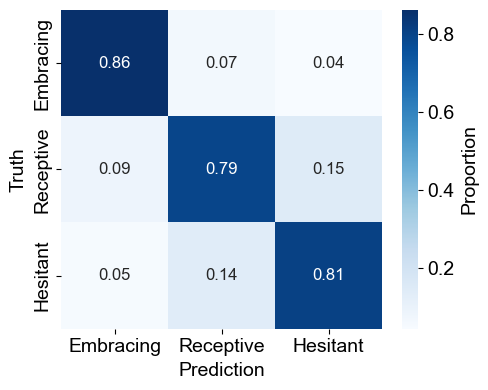

In [17]:
# 混淆矩阵
print("\nPlotting a confusion matrix...")
cm = confusion_matrix(y, y_pred_cv)

cm1 = cm / sum(cm)
print(cm1)

# 可视化混淆矩阵
plt.figure(figsize=(5, 4))
plt.rc('font', family='Arial', weight='normal')

# 创建热图并获取colorbar对象
heatmap = sns.heatmap(
    cm1, 
    annot=True, 
    fmt='.2f', 
    cmap='Blues',
    annot_kws={'size': 12},  # 设置图块标记字体大小为12
    cbar_kws={'label': 'accuracy'},  # 设置colorbar标签为accuracy
    xticklabels=['Embracing', 'Receptive', 'Hesitant'],
    yticklabels=['Embracing', 'Receptive', 'Hesitant']
)

# 设置colorbar字体为12
cbar = heatmap.collections[0].colorbar
cbar.ax.tick_params(labelsize=14)
cbar.ax.set_ylabel('Proportion', fontsize=14)  # 设置colorbar标签字体大小

# 设置坐标轴标签和刻度
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Prediction', fontsize=14)  # 添加x轴标签
plt.ylabel('Truth', fontsize=14)

plt.tight_layout()
# plt.savefig( r'CM_mlp.png', dpi=300,transparent=True,bbox_inches = 'tight')
plt.show()